In [1]:
from dataloader import DataLoader
loader = DataLoader()

_initialize_data took 70.2991 seconds


In [2]:
df = loader.get_data(hs_code=282520)

## Graph Machine Learning

In [3]:
import polars as pl
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
import torch.nn.functional as F
import networkx as nx
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

###################################################
# Parameters
###################################################
product_code = 282520
start_year = 2005
end_year = 2022
window_size = 3
epochs = 50
lr = 0.01
embedding_dim = 32
hidden_dim = 64

# Device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

###################################################
# Load and Filter Data
###################################################
df_lithium = df.filter(pl.col("k") == product_code)

all_years = sorted(df_lithium.select(pl.col("t")).unique().to_series().to_list())
years_of_interest = [y for y in all_years if start_year <= y <= end_year]

if len(years_of_interest) < 2:
    raise ValueError("Not enough years of data for temporal analysis.")

pdf_lithium = df_lithium.to_pandas()
all_countries = np.union1d(pdf_lithium['export_country'].unique(), pdf_lithium['import_country'].unique())
country_to_id = {c: i for i, c in enumerate(all_countries)}
num_nodes = len(all_countries)

/Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN5torch8autograd13_wrap_outputsERKNSt3__16vectorIN2at6TensorENS1_9allocatorIS4_EEEERKNS1_13unordered_setIPN3c1010TensorImplENS1_4hashISD_EENS1_8equal_toISD_EENS5_ISD_EEEESL_NSB_8ArrayRefINSB_8optionalIS4_EEEERKNS1_10shared_ptrINS0_4NodeEEENS1_8functionIFS7_S7_S7_EEE
  Referenced from: <447516A9-D5D9-348C-9CE2-78924C2F3E65> /Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Scie

Using device: cpu


In [4]:
###################################################
# Node Feature Builder
###################################################
def build_node_features_for_year(year_data, all_countries):
    # If GDP features not available, use zero features
    if 'gdpcap_o' not in year_data.columns or 'gdpcap_d' not in year_data.columns:
        node_features = np.zeros((len(all_countries), 2))
        return torch.tensor(node_features, dtype=torch.float)

    export_gdp = year_data.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = year_data.groupby("import_country")["gdpcap_o"].mean().to_dict()

    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        node_features.append([gdp_o_val, gdp_d_val])
    return torch.tensor(node_features, dtype=torch.float)

In [5]:
###################################################
# Graph Snapshots for each Year
###################################################
edge_feature_cols = ["v"]
scaler = StandardScaler()
all_edge_attrs = pdf_lithium[edge_feature_cols].fillna(0.0)
scaler.fit(all_edge_attrs)

def build_graph_for_year(year):
    year_pdf = pdf_lithium[pdf_lithium['t'] == year]
    if year_pdf.empty:
        return Data(x=torch.zeros((num_nodes,2)), edge_index=torch.empty((2,0), dtype=torch.long))

    x = build_node_features_for_year(year_pdf, all_countries)
    src = year_pdf['export_country'].map(country_to_id)
    dst = year_pdf['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)

    attrs = year_pdf[edge_feature_cols].fillna(0.0).values
    attrs = scaler.transform(attrs)
    edge_attr = torch.tensor(attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

year_graphs = []
for y in years_of_interest:
    data_y = build_graph_for_year(y)
    year_graphs.append((y, data_y))

In [6]:
###################################################
# GCN Encoder
###################################################
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [7]:
###################################################
# Training for Yearly Embeddings
###################################################
year_embeddings = {}

for y, data_y in year_graphs:
    data_y = data_y.to(device)
    encoder = GCNEncoder(in_channels=data_y.x.size(1),
                         hidden_channels=hidden_dim,
                         out_channels=embedding_dim)
    model = GAE(encoder=encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    rev_edge_index = torch.stack([data_y.edge_index[1], data_y.edge_index[0]], dim=0)
    full_edge_index = torch.cat([data_y.edge_index, rev_edge_index], dim=1)
    data_y.edge_index = full_edge_index

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data_y.x, data_y.edge_index)
        loss = model.recon_loss(z, data_y.edge_index)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        z = model.encode(data_y.x, data_y.edge_index)
    year_embeddings[y] = z.cpu().numpy()

In [8]:
###################################################
# Sliding Window Analysis of Network Structure
###################################################
def build_nx_graph_from_edges(edge_index):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for j in range(edge_index.size(1)):
        u = edge_index[0, j].item()
        v = edge_index[1, j].item()
        G.add_edge(u, v)
    return G

window_metrics = []
for i in range(len(years_of_interest) - window_size + 1):
    window_years = years_of_interest[i:i+window_size]
    combined_edge_index = []
    for wy in window_years:
        idx = years_of_interest.index(wy)
        ei = year_graphs[idx][1].edge_index
        combined_edge_index.append(ei)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    
    combined_edge_index = torch.unique(combined_edge_index, dim=1)
    
    G_window = build_nx_graph_from_edges(combined_edge_index)
    
    deg_centrality = nx.degree_centrality(G_window)
    bet_centrality = nx.betweenness_centrality(G_window)
    communities = nx.algorithms.community.greedy_modularity_communities(G_window)
    num_communities = len(communities)
    
    window_metrics.append({
        'start_year': window_years[0],
        'end_year': window_years[-1],
        'avg_degree_centrality': np.mean(list(deg_centrality.values())),
        'avg_betweenness_centrality': np.mean(list(bet_centrality.values())),
        'num_communities': num_communities
    })

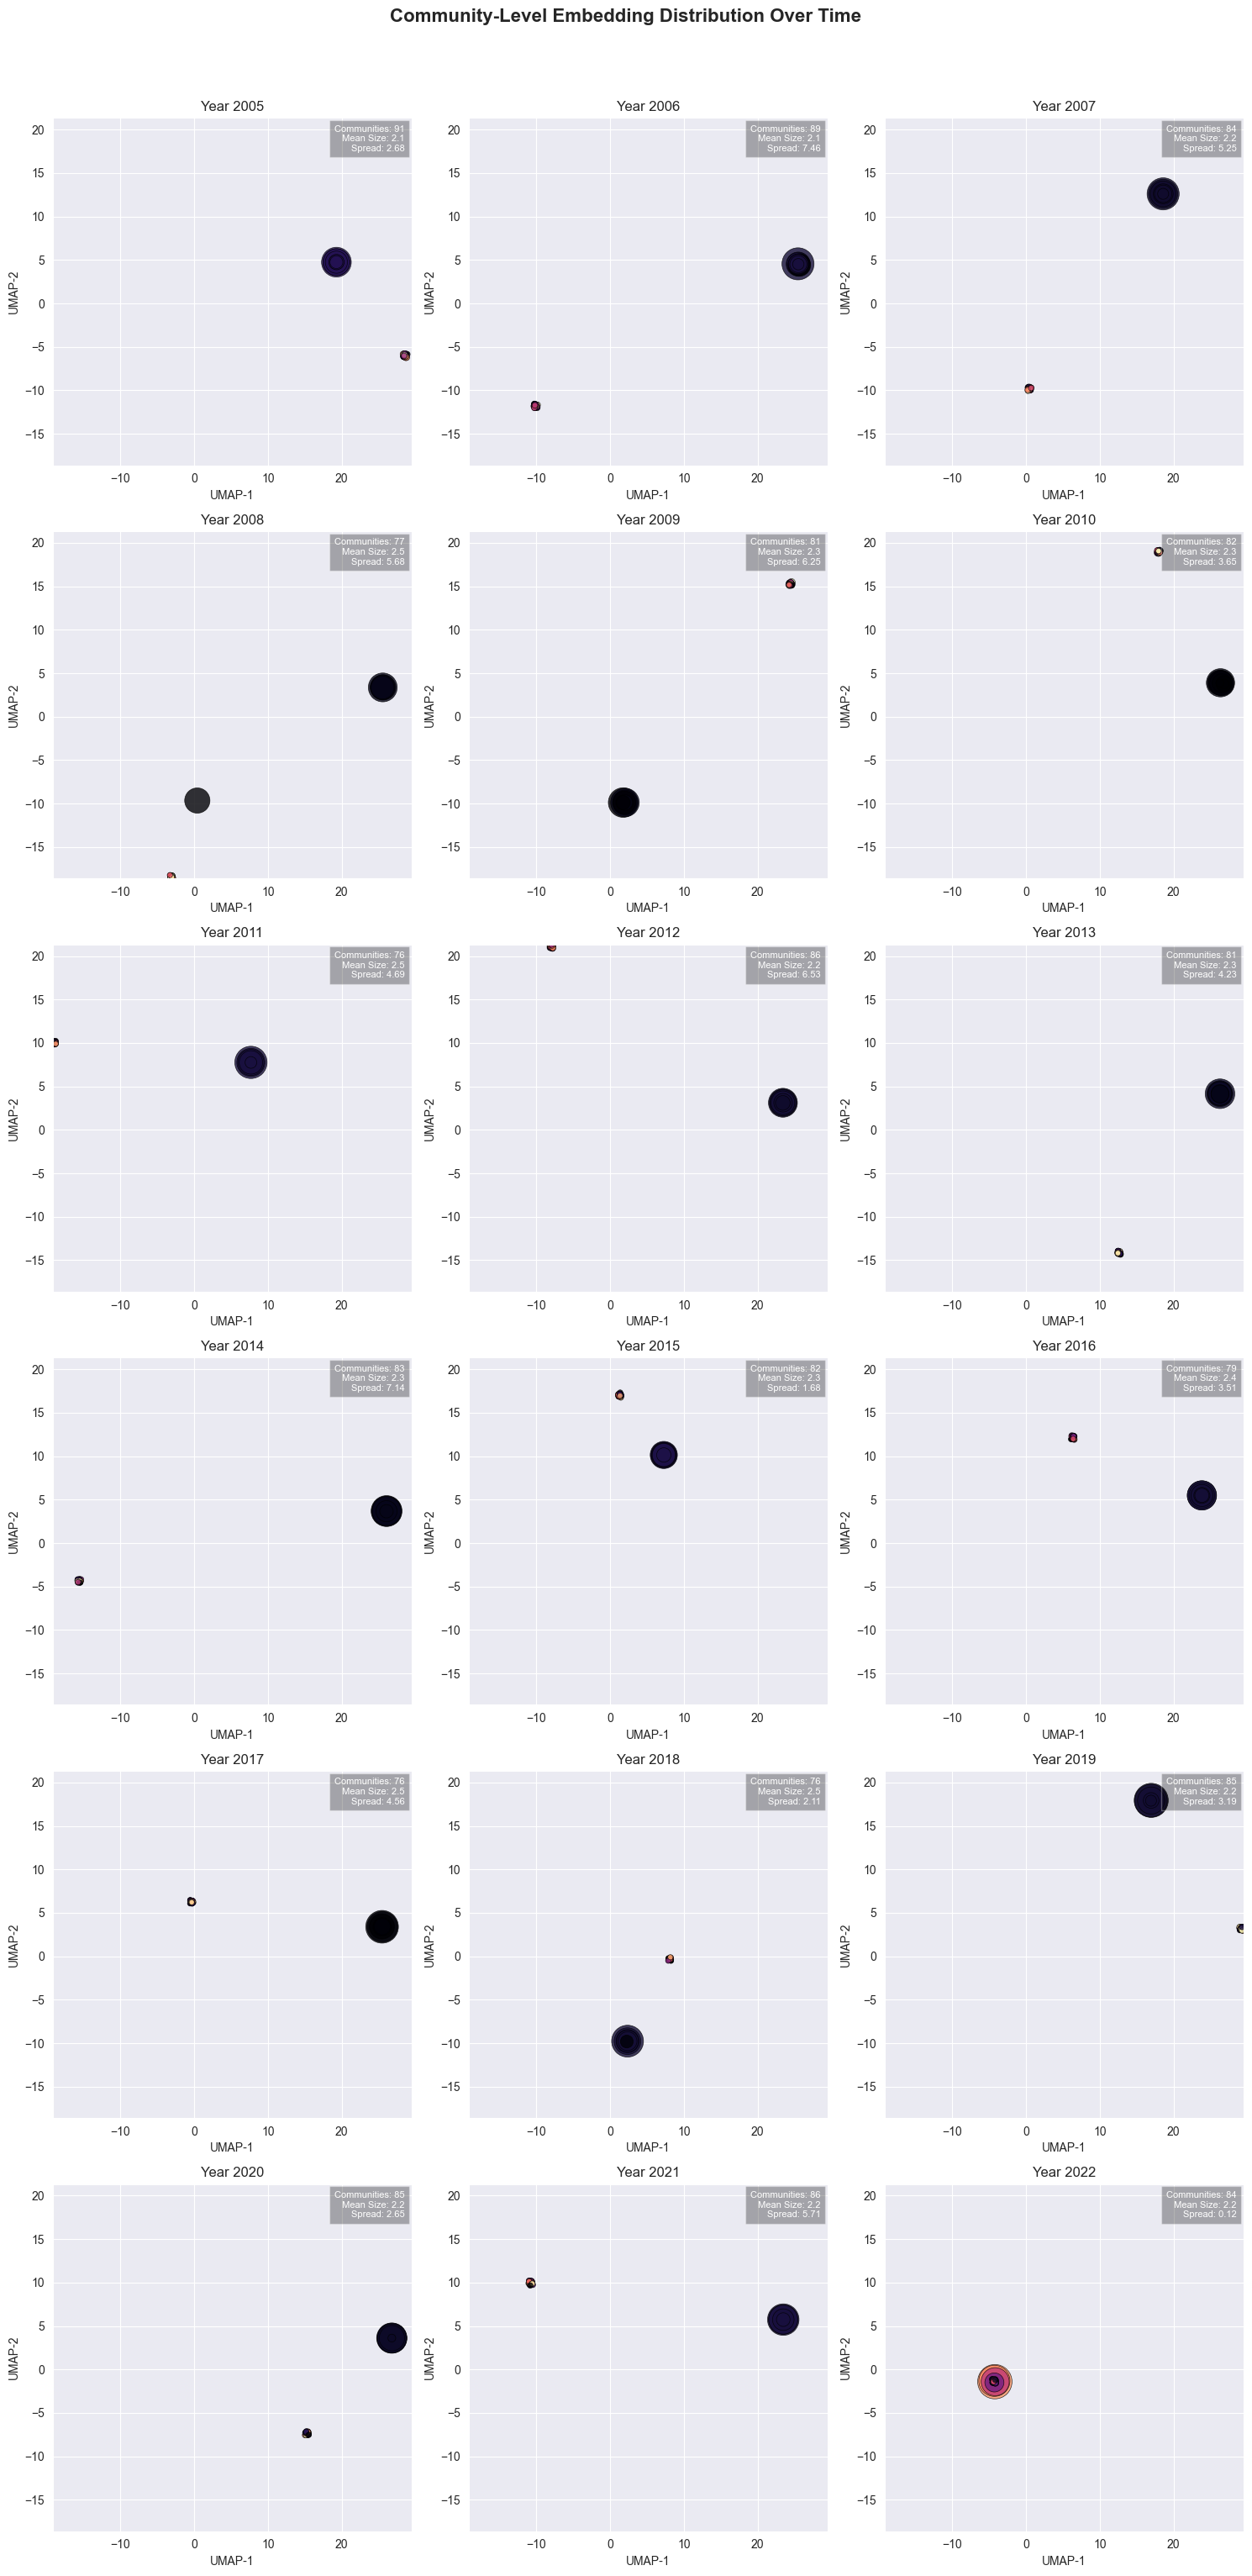

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from scipy.stats import gaussian_kde

num_nodes = len(all_countries)
embedding_dim = list(year_embeddings.values())[0].shape[1]

###################################################
# 1. Community Aggregation by Year
###################################################
def get_communities_for_year(data_y):
    G_y = nx.Graph()
    G_y.add_nodes_from(range(num_nodes))
    for j in range(data_y.edge_index.size(1)):
        u = data_y.edge_index[0, j].item()
        v = data_y.edge_index[1, j].item()
        G_y.add_edge(u, v)
    communities = nx.algorithms.community.greedy_modularity_communities(G_y)
    return communities

year_communities = {}
for y, data_y in year_graphs:
    year_communities[y] = get_communities_for_year(data_y)

###################################################
# Community-Level Embeddings
###################################################
year_comm_embeddings = {}
year_comm_sizes = {}
for y in years_of_interest:
    emb = year_embeddings[y]
    comms = year_communities[y]

    comm_embs = []
    comm_sizes = []
    for cset in comms:
        c_indices = list(cset)
        c_emb = emb[c_indices].mean(axis=0)
        comm_embs.append(c_emb)
        comm_sizes.append(len(c_indices))
    comm_embs = np.array(comm_embs)
    year_comm_embeddings[y] = comm_embs
    year_comm_sizes[y] = np.array(comm_sizes)

all_comm_embeddings = []
comm_labels = []
for y in years_of_interest:
    cemb = year_comm_embeddings[y]
    for i in range(cemb.shape[0]):
        all_comm_embeddings.append(cemb[i])
        comm_labels.append((y, i))

all_comm_embeddings = np.vstack(all_comm_embeddings)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
all_comm_2d = reducer.fit_transform(all_comm_embeddings)

x_min, x_max = all_comm_2d[:,0].min(), all_comm_2d[:,0].max()
y_min, y_max = all_comm_2d[:,1].min(), all_comm_2d[:,1].max()

cols = 3
rows = math.ceil(len(years_of_interest)/cols)
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axs = axs.flatten()

###################################################
# Plot Years Arranged in a Grid
###################################################
for idx, y in enumerate(years_of_interest):
    year_indices = [i for i, (yr, _) in enumerate(comm_labels) if yr == y]
    year_embs_2d = all_comm_2d[year_indices]
    x = year_embs_2d[:,0]
    yy = year_embs_2d[:,1]

    xy = np.vstack([x, yy])
    z = gaussian_kde(xy)(xy)
    
    comm_sizes = year_comm_sizes[y]
    size_scaled = 50 * (comm_sizes / comm_sizes.mean())

    ax = axs[idx]
    sc = ax.scatter(x, yy, c=z, cmap='magma', s=size_scaled, alpha=0.8, edgecolors='black', linewidths=0.5)
    ax.set_title(f"Year {y}", fontsize=12)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

    n_comms = len(comm_sizes)
    mean_size = comm_sizes.mean()
    spread = np.sqrt((x.var() + yy.var())/2.0)

    summary_text = (f"Communities: {n_comms}\n"
                    f"Mean Size: {mean_size:.1f}\n"
                    f"Spread: {spread:.2f}")
    ax.text(0.98, 0.98, summary_text, transform=ax.transAxes, 
            va='top', ha='right', fontsize=8,
            bbox=dict(facecolor='black', alpha=0.3, pad=4),
            color='white')

for i in range(len(years_of_interest), len(axs)):
    fig.delaxes(axs[i])

fig.suptitle("Community-Level Embedding Distribution Over Time", fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


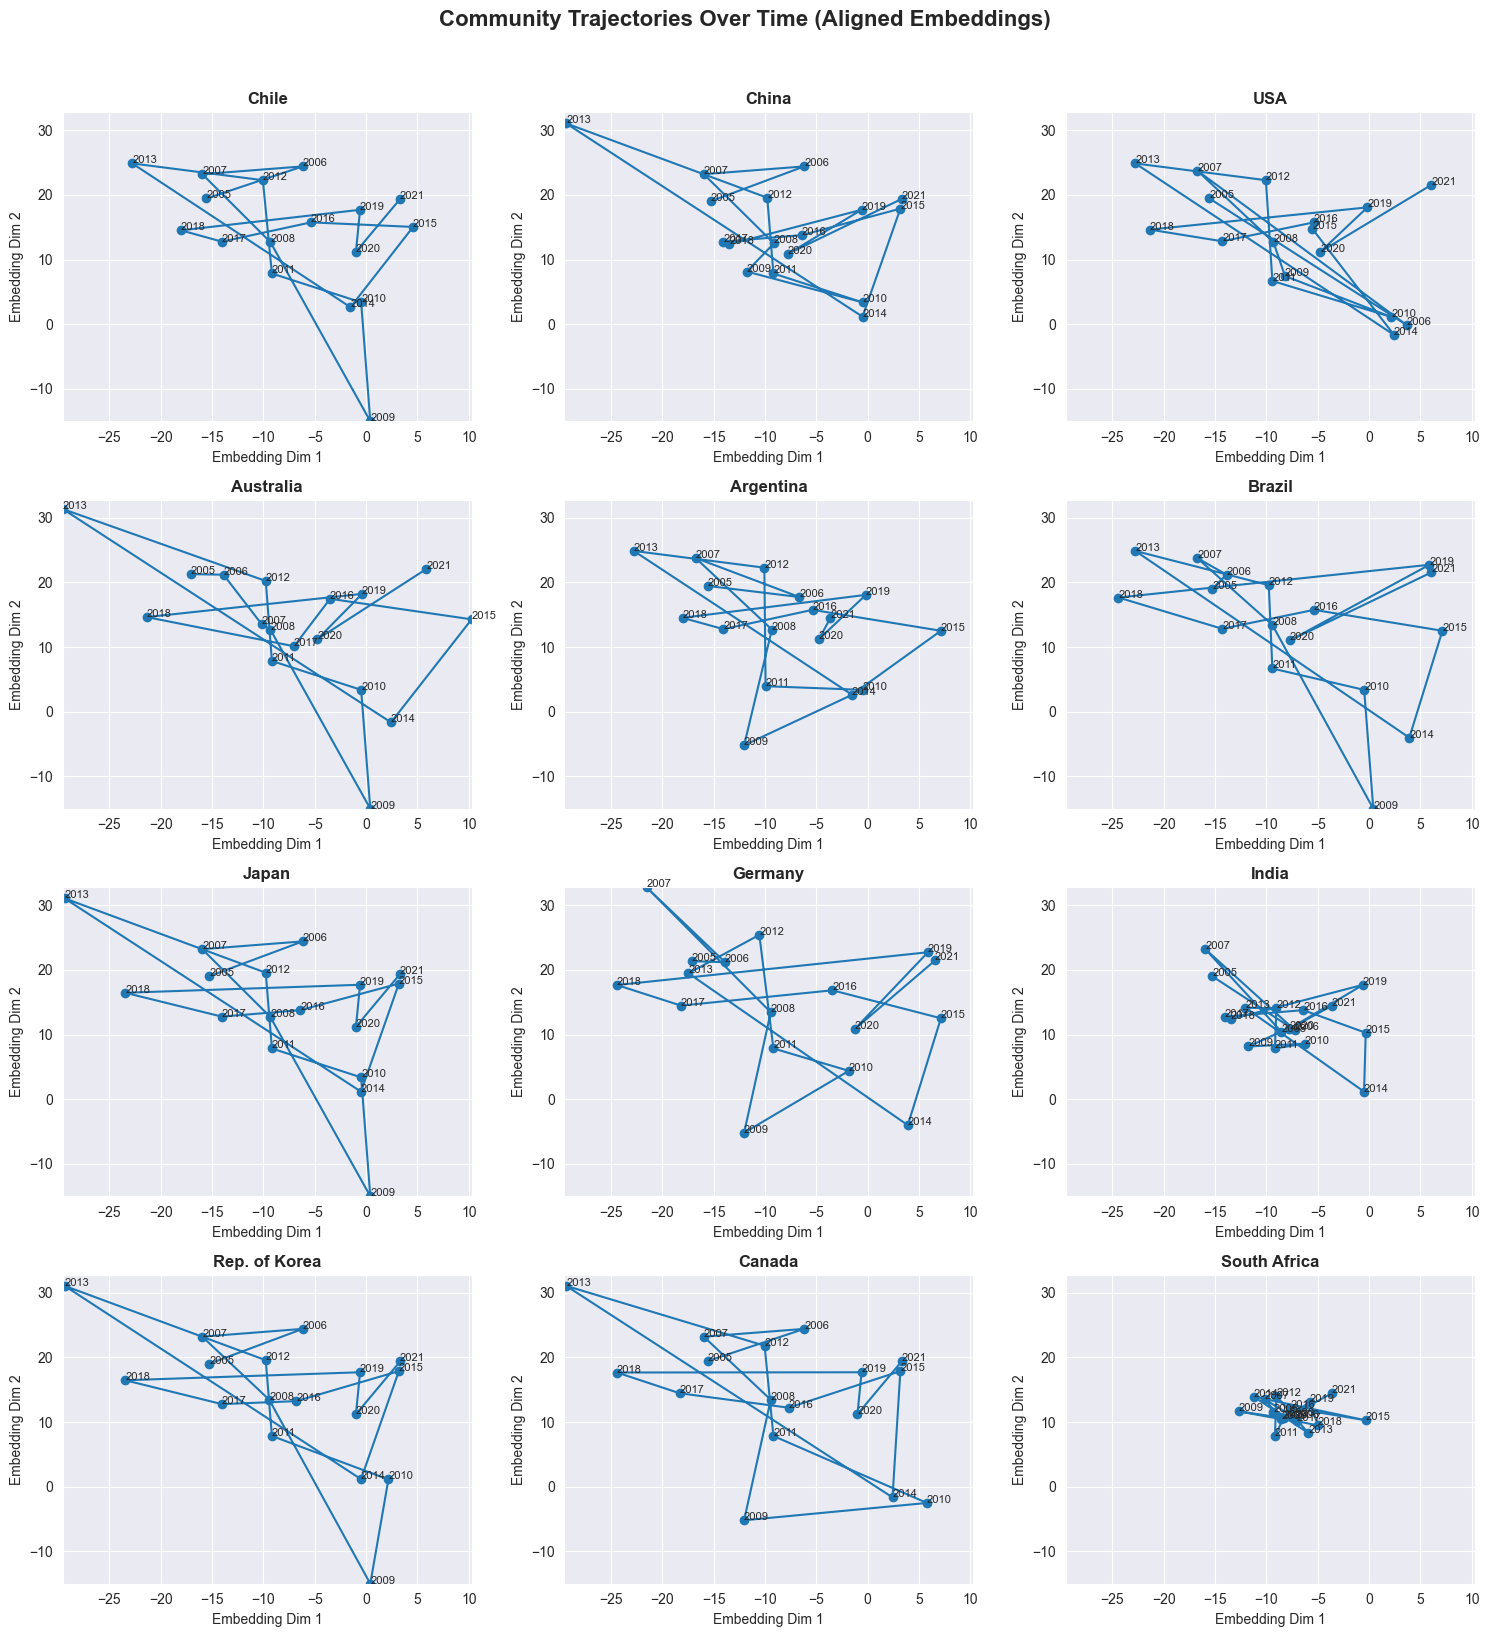

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

num_nodes = len(all_countries)
embedding_dim = 32
hidden_dim = 64
epochs = 50
lr = 0.01

def build_graph_for_year(year):
    year_pdf = pdf_lithium[pdf_lithium['t'] == year]
    if year_pdf.empty:
        data = Data(x=torch.zeros((num_nodes, 2)), edge_index=torch.empty((2,0), dtype=torch.long))
        return data

    x = build_node_features_for_year(year_pdf, all_countries)
    src = year_pdf['export_country'].map(country_to_id)
    dst = year_pdf['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)

    attrs = year_pdf[edge_feature_cols].fillna(0.0).values
    attrs = scaler.transform(attrs)
    edge_attr = torch.tensor(attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

year_graphs = []
for y in years_of_interest:
    year_graphs.append((y, build_graph_for_year(y)))

##############################################
# GCN Encoder for GAE
##############################################
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

##############################################
# Training
##############################################
year_embeddings = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Couldn't make mps work here for some reason

for y, data_y in year_graphs:
    data_y = data_y.to(device)

    encoder = GCNEncoder(in_channels=data_y.x.size(1), hidden_channels=hidden_dim, out_channels=embedding_dim)
    model = GAE(encoder=encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    rev_edge_index = torch.stack([data_y.edge_index[1], data_y.edge_index[0]], dim=0)
    full_edge_index = torch.cat([data_y.edge_index, rev_edge_index], dim=1)
    data_y.edge_index = full_edge_index

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data_y.x, data_y.edge_index)
        loss = model.recon_loss(z, data_y.edge_index)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        z = model.encode(data_y.x, data_y.edge_index)
    year_embeddings[y] = z.cpu().numpy()

##############################################
# Alignment of Embeddings over Time
##############################################
def align_embeddings(ref_emb, target_emb):
    ref_mean = ref_emb.mean(axis=0, keepdims=True)
    tgt_mean = target_emb.mean(axis=0, keepdims=True)
    ref_centered = ref_emb - ref_mean
    tgt_centered = target_emb - tgt_mean
    U, S, Vt = np.linalg.svd(ref_centered.T @ tgt_centered)
    R = U @ Vt
    aligned = (tgt_centered @ R)
    aligned *= (np.linalg.norm(ref_centered) / np.linalg.norm(aligned))
    aligned += ref_mean
    return aligned

ref_year = years_of_interest[0]
ref_emb = year_embeddings[ref_year]
for y in years_of_interest[1:]:
    year_embeddings[y] = align_embeddings(ref_emb, year_embeddings[y])

##############################################
# Community Detection and Tracking
##############################################
year_communities = {}
for y, data_y in year_graphs:
    ei = data_y.edge_index.cpu().numpy() if data_y.edge_index.numel() > 0 else np.empty((2,0),dtype=int)
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for j in range(ei.shape[1]):
        G.add_edge(ei[0,j], ei[1,j])
    comms = nx.algorithms.community.greedy_modularity_communities(G)
    year_communities[y] = comms

def find_community_for_country(comms, cid):
    for i, cset in enumerate(comms):
        if cid in cset:
            return i
    return None

##############################################
# Visualization of Country Trajectory
##############################################
key_countries = [
    "Chile", "China", "USA", "Australia", "Argentina", 
    "Brazil", "Japan", "Germany", "India", "Rep. of Korea", 
    "Canada", "South Africa"
]

country_ids = {c: country_to_id[c] for c in key_countries if c in country_to_id}

country_trajectories = {}
all_coords = []

for ctry, cid in country_ids.items():
    community_positions_over_time = []
    for y in years_of_interest:
        comms = year_communities[y]
        c_idx = find_community_for_country(comms, cid)
        if c_idx is not None:
            emb = year_embeddings[y]
            c_indices = list(comms[c_idx])
            c_position = emb[c_indices].mean(axis=0)
            community_positions_over_time.append((y, c_position))
    country_trajectories[ctry] = community_positions_over_time

    if len(community_positions_over_time) > 0:
        _, coords = zip(*community_positions_over_time)
        coords = np.array(coords)
        all_coords.append(coords)

if len(all_coords) > 0:
    all_coords_stacked = np.vstack(all_coords)
    x_min = np.nanmin(all_coords_stacked[:,0])
    x_max = np.nanmax(all_coords_stacked[:,0])
    y_min = np.nanmin(all_coords_stacked[:,1])
    y_max = np.nanmax(all_coords_stacked[:,1])
    
else:
    x_min, x_max, y_min, y_max = -1, 1, -1, 1

num_countries = len(country_trajectories)
cols = 3
rows = (num_countries + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs = axs.flatten()

for i, (ctry, traj) in enumerate(country_trajectories.items()):
    ax = axs[i]
    if len(traj) > 0:
        ys, coords = zip(*traj)
        coords = np.array(coords)
        ax.plot(coords[:,0], coords[:,1], marker='o')
        for j, yy in enumerate(ys):
            ax.text(coords[j,0], coords[j,1], str(yy), fontsize=8)

        ax.set_title(f"{ctry}", fontweight="bold")
        ax.set_xlabel("Embedding Dim 1")
        ax.set_ylabel("Embedding Dim 2")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        ax.text(0.5,0.5,"No Data",ha='center',va='center',fontsize=10)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Embedding Dim 1")
        ax.set_ylabel("Embedding Dim 2")

for k in range(num_countries, rows*cols):
    fig.delaxes(axs[k])

fig.suptitle("Community Trajectories Over Time (Aligned Embeddings)", fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

## Attack Simulation

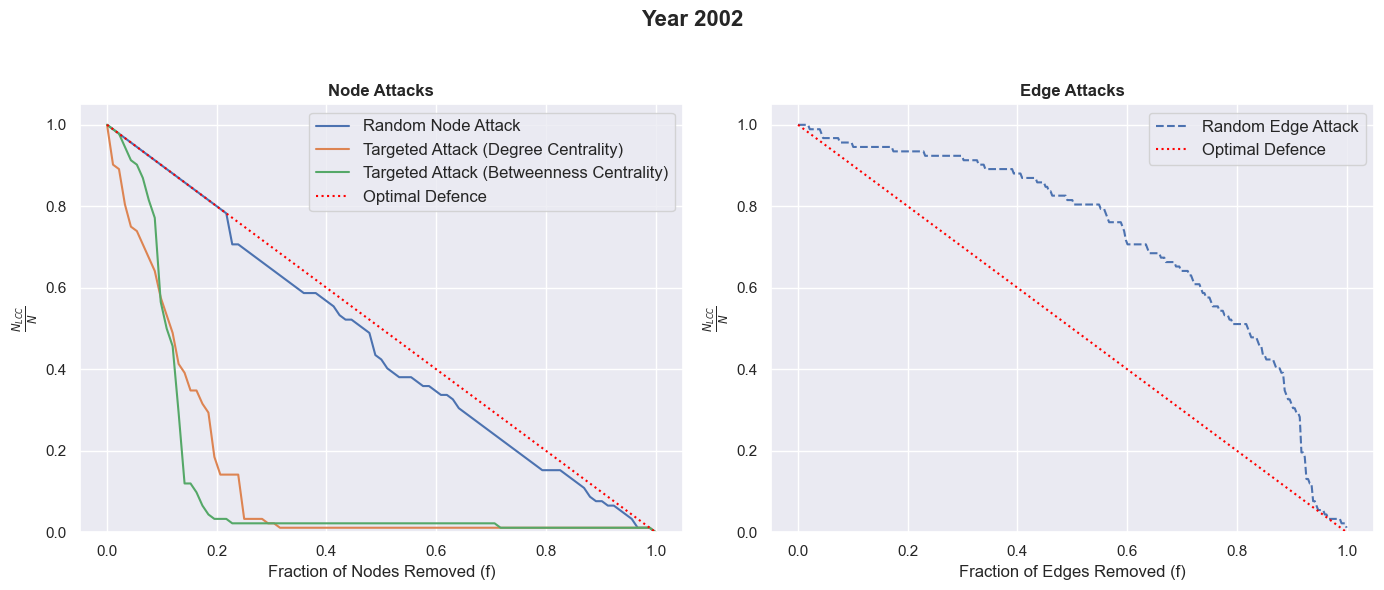

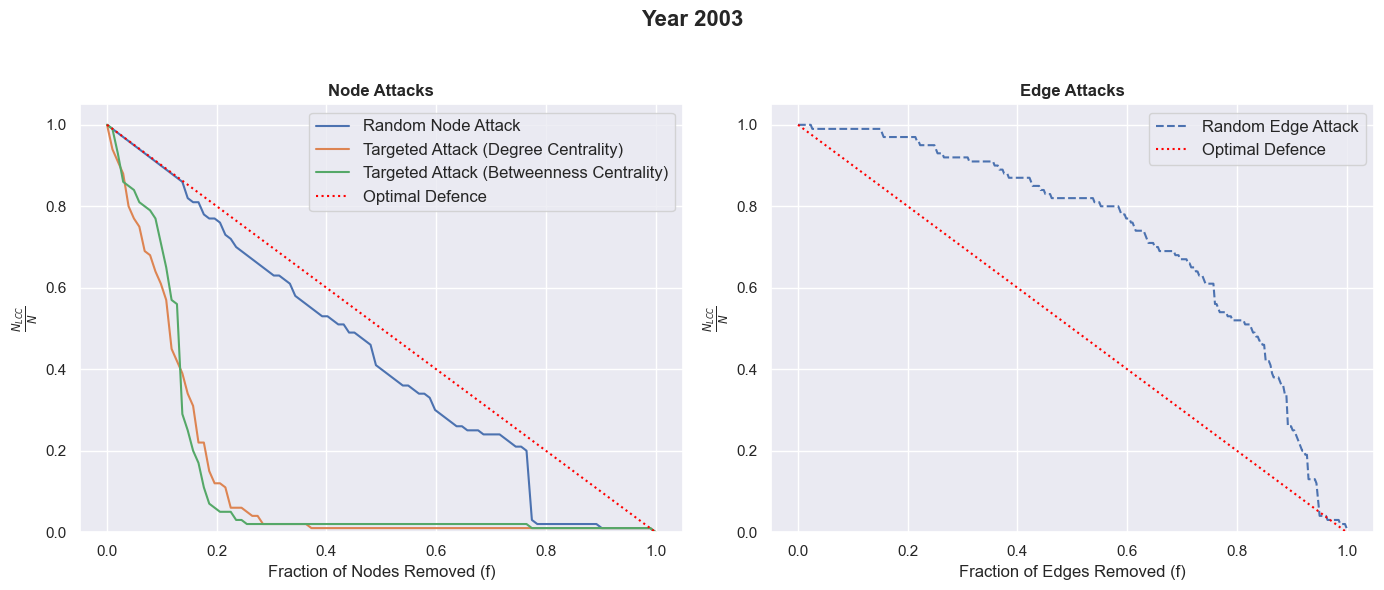

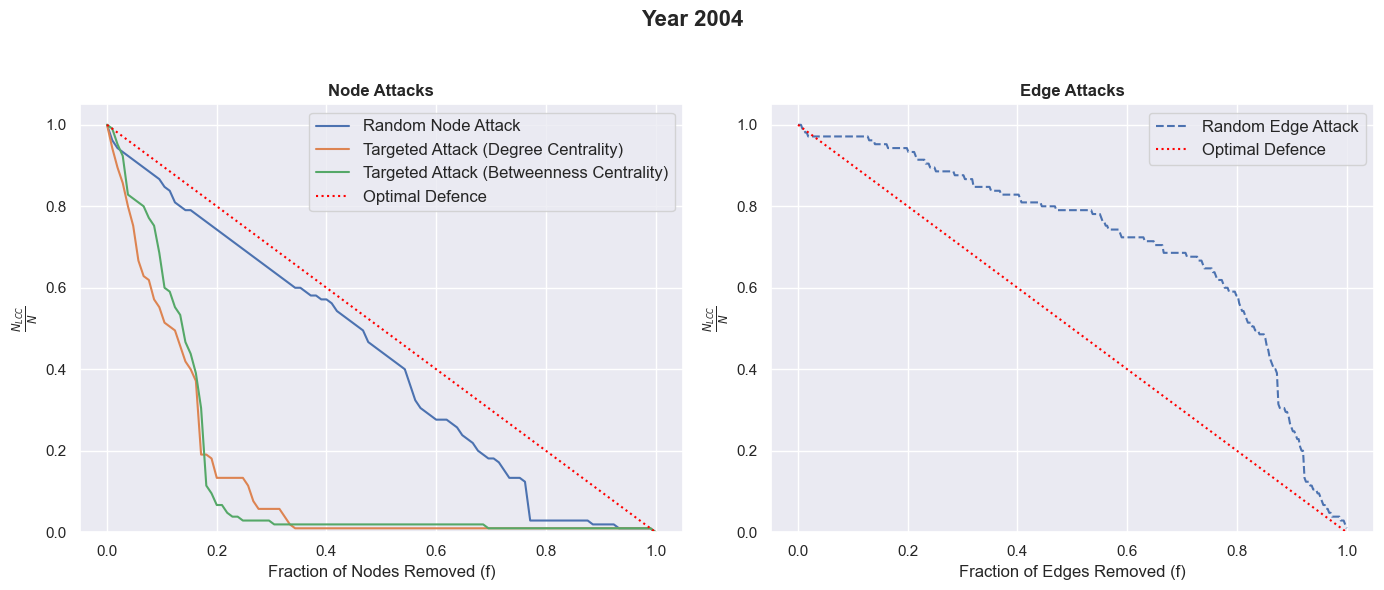

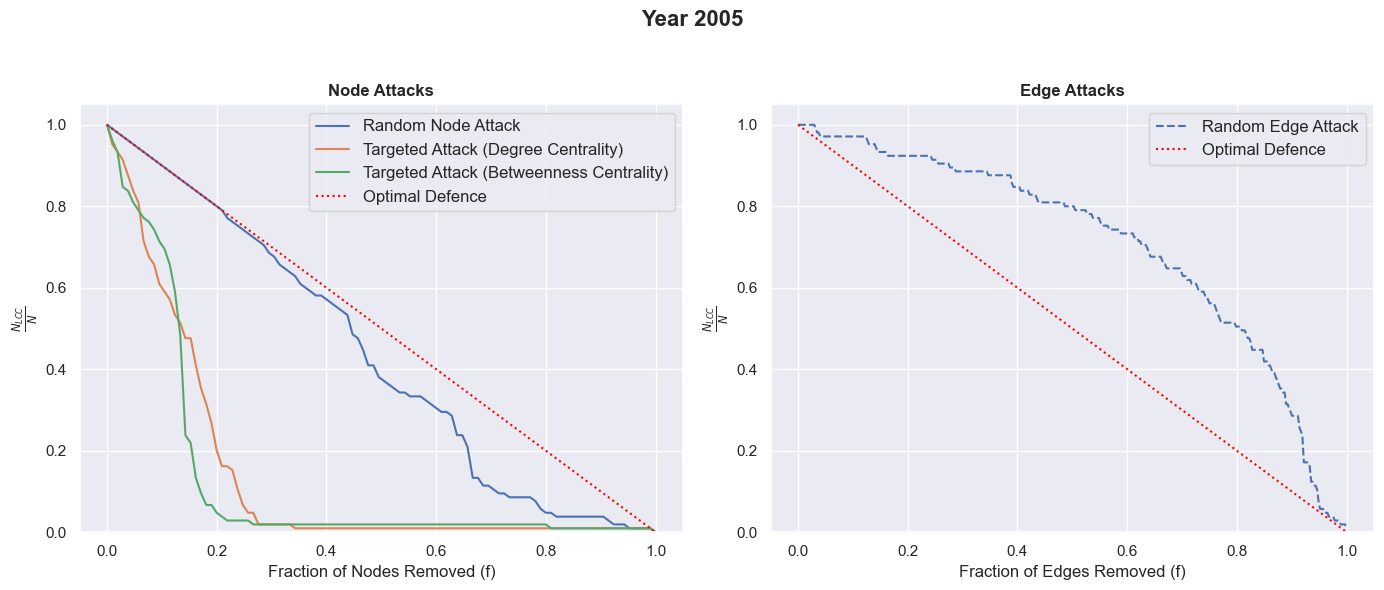

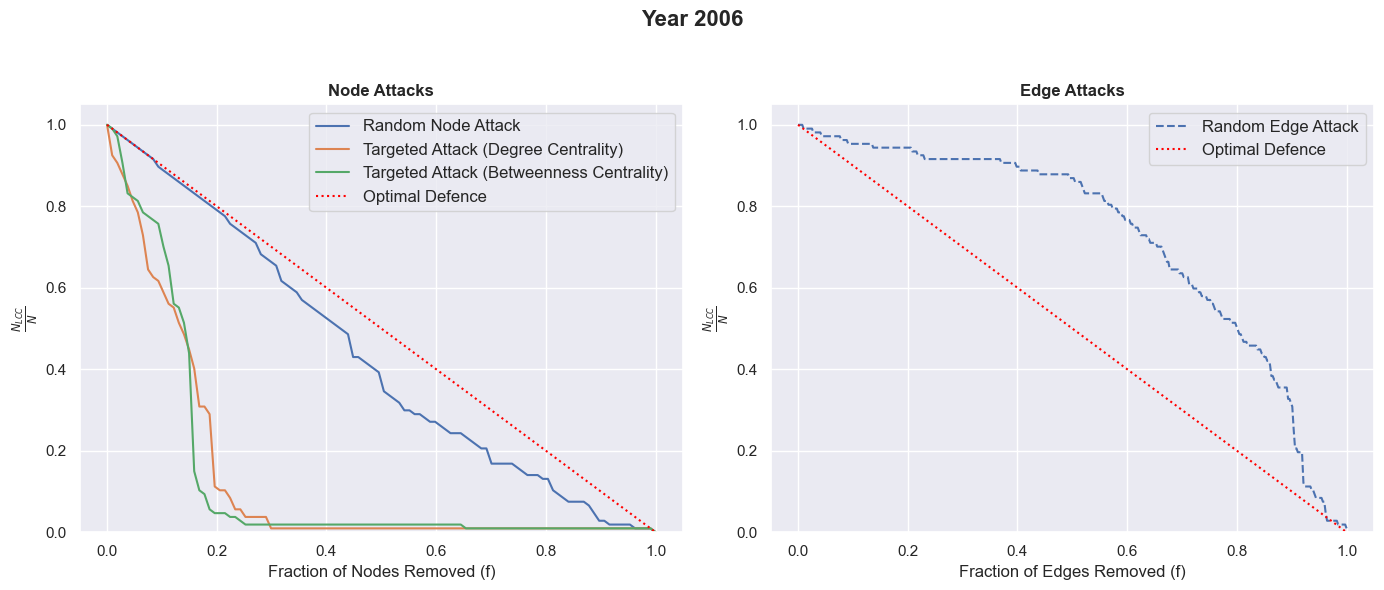

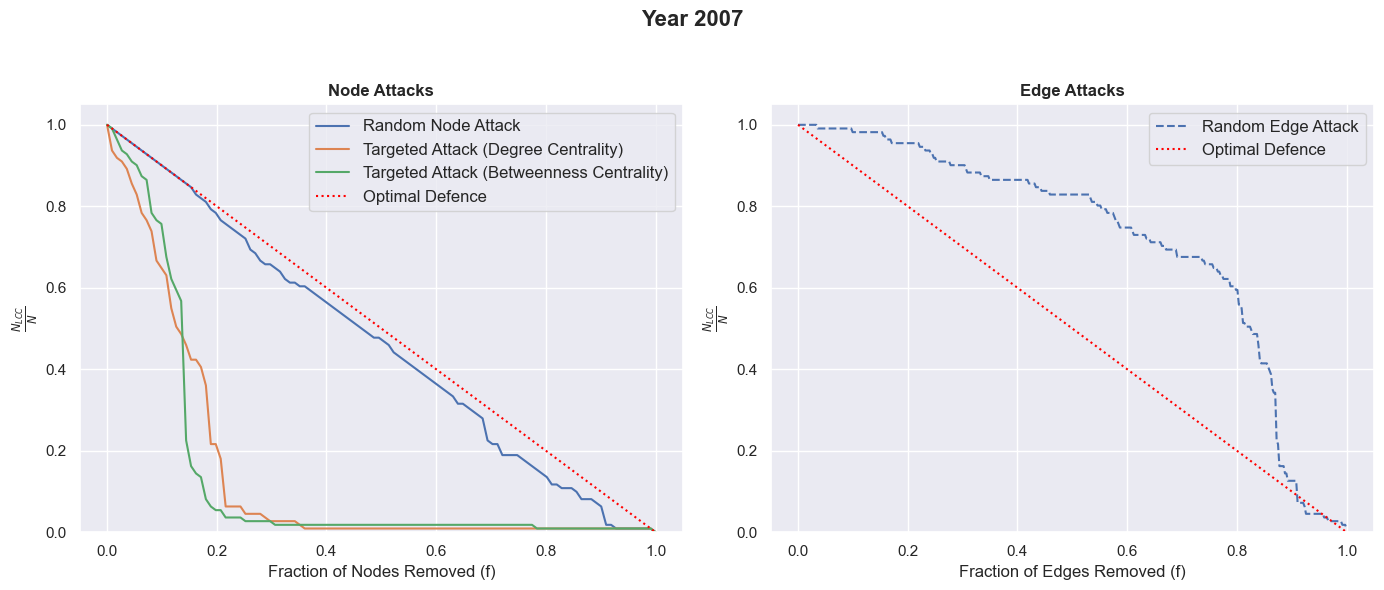

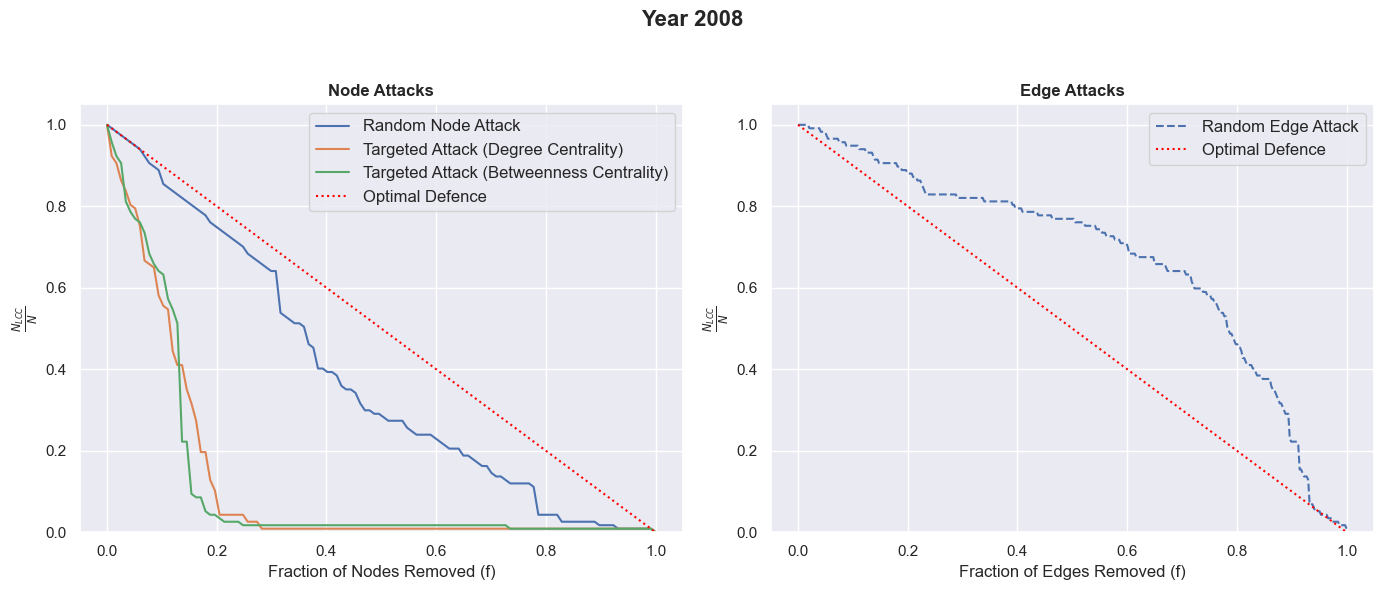

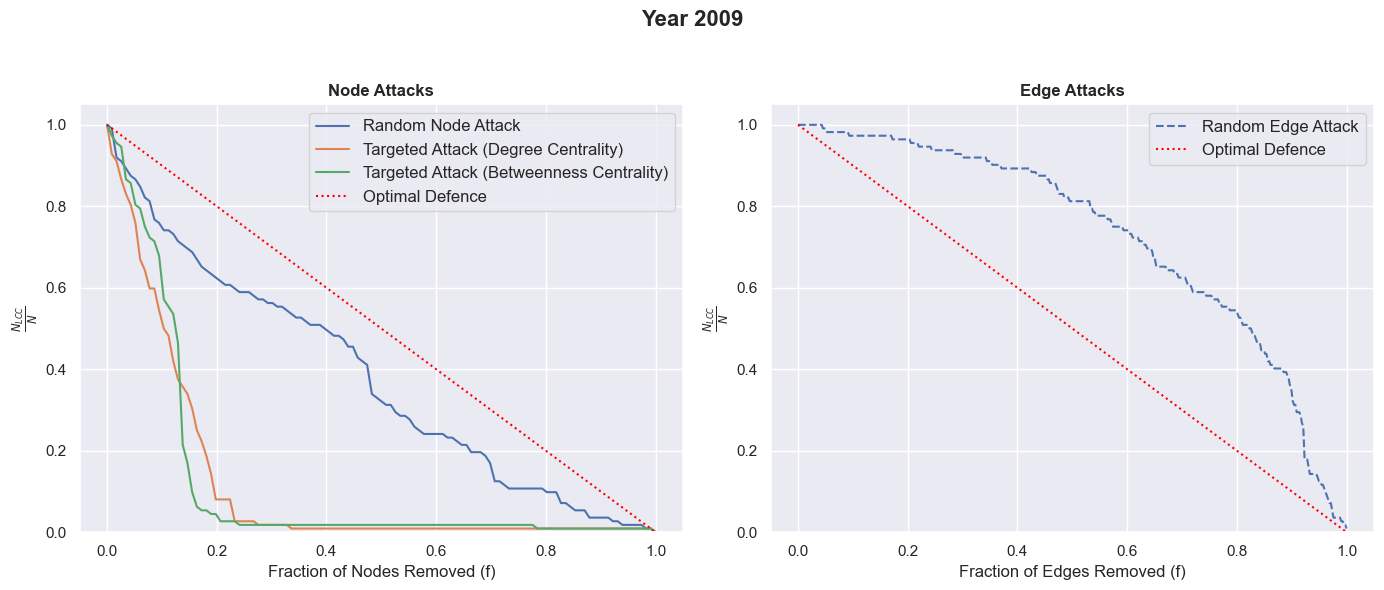

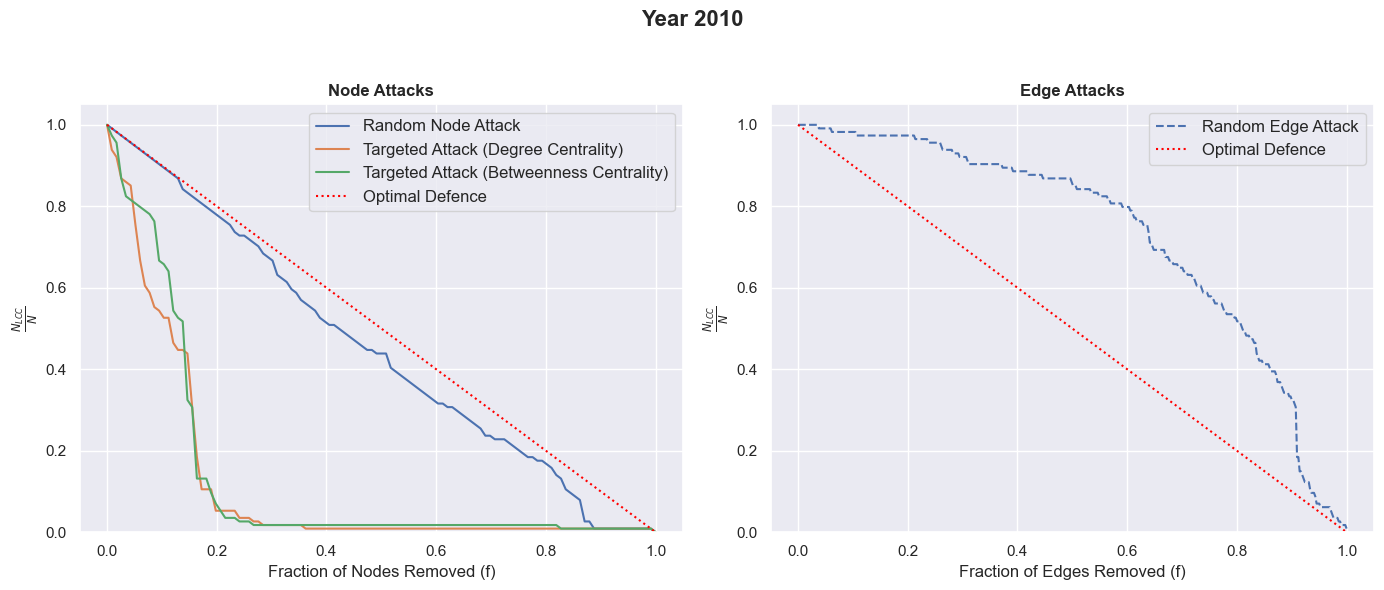

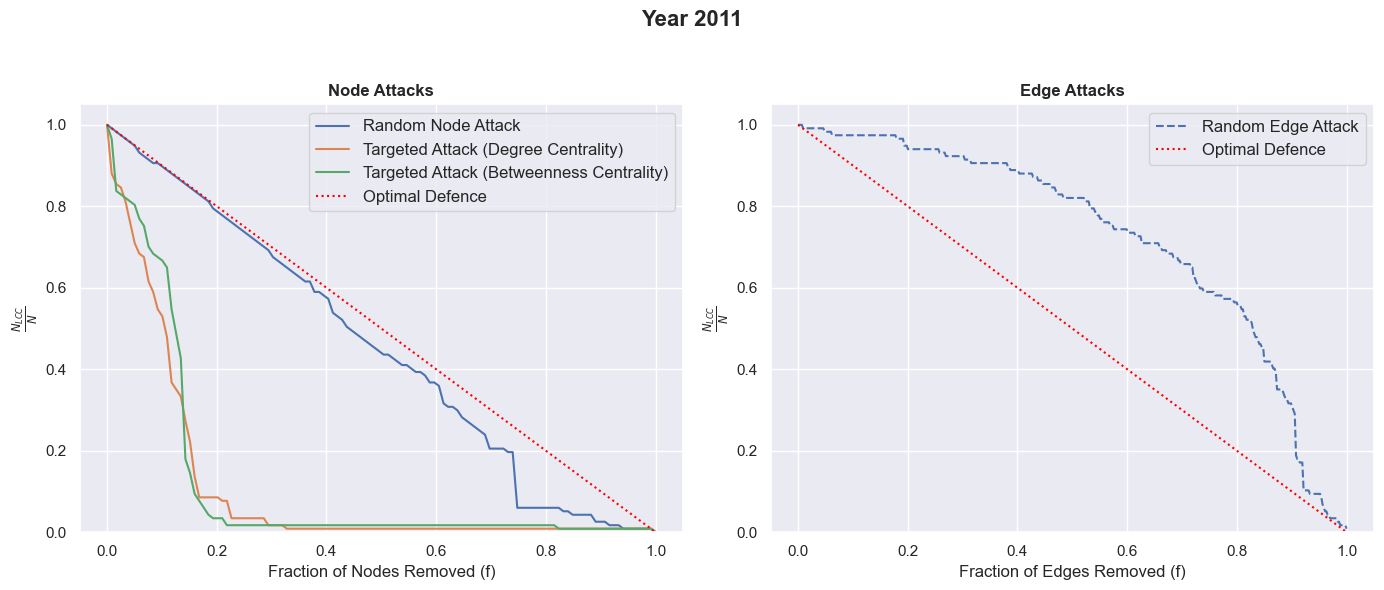

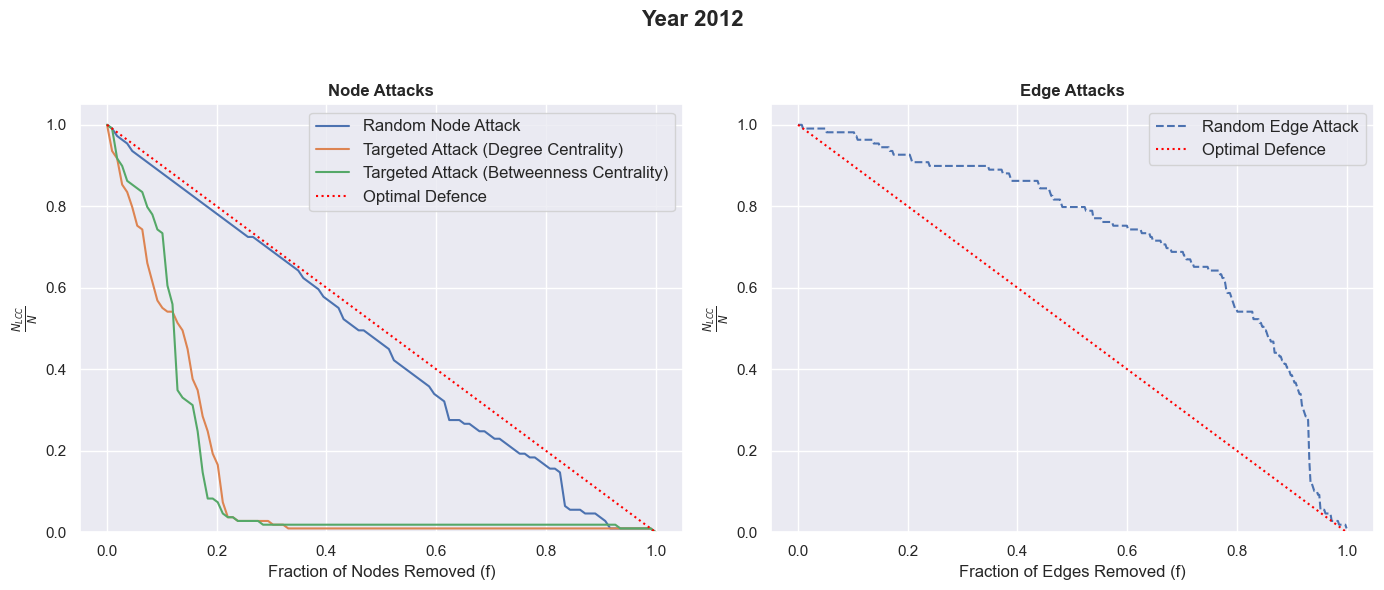

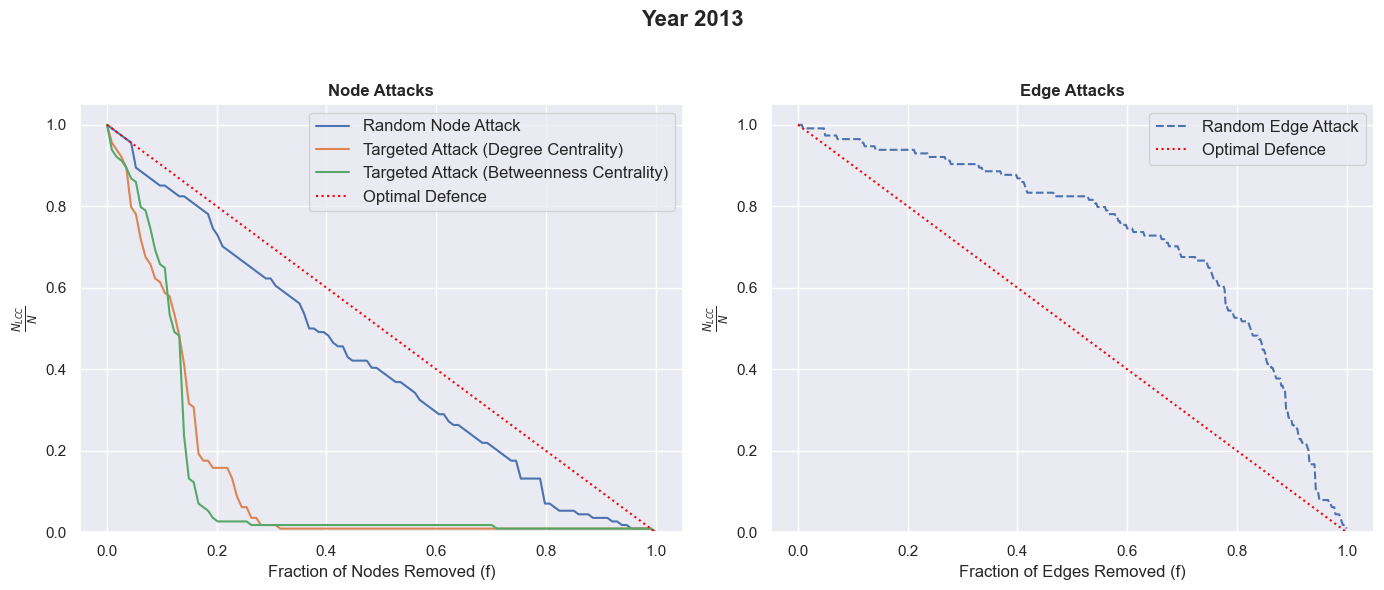

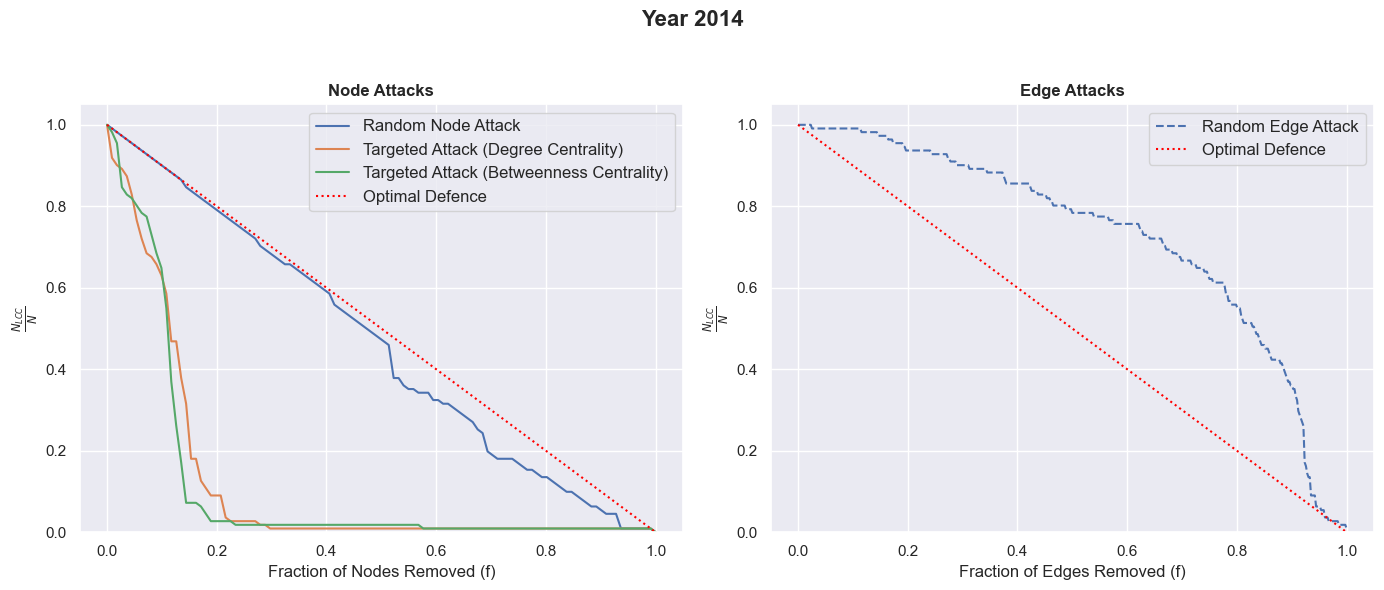

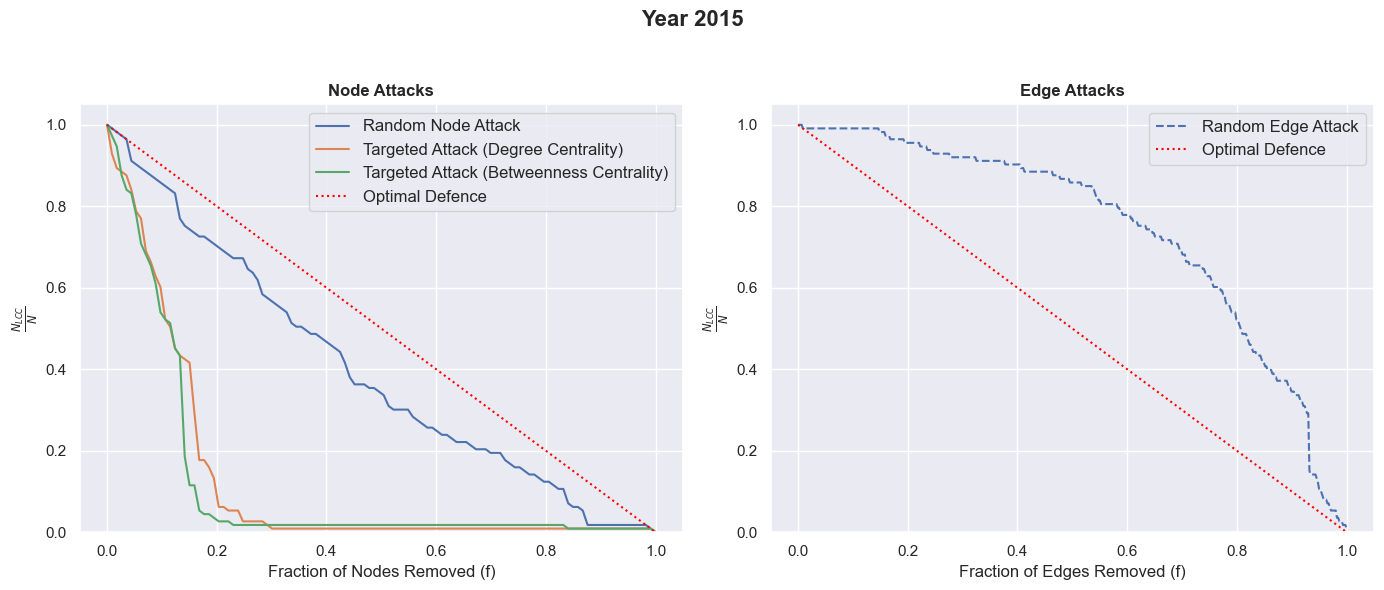

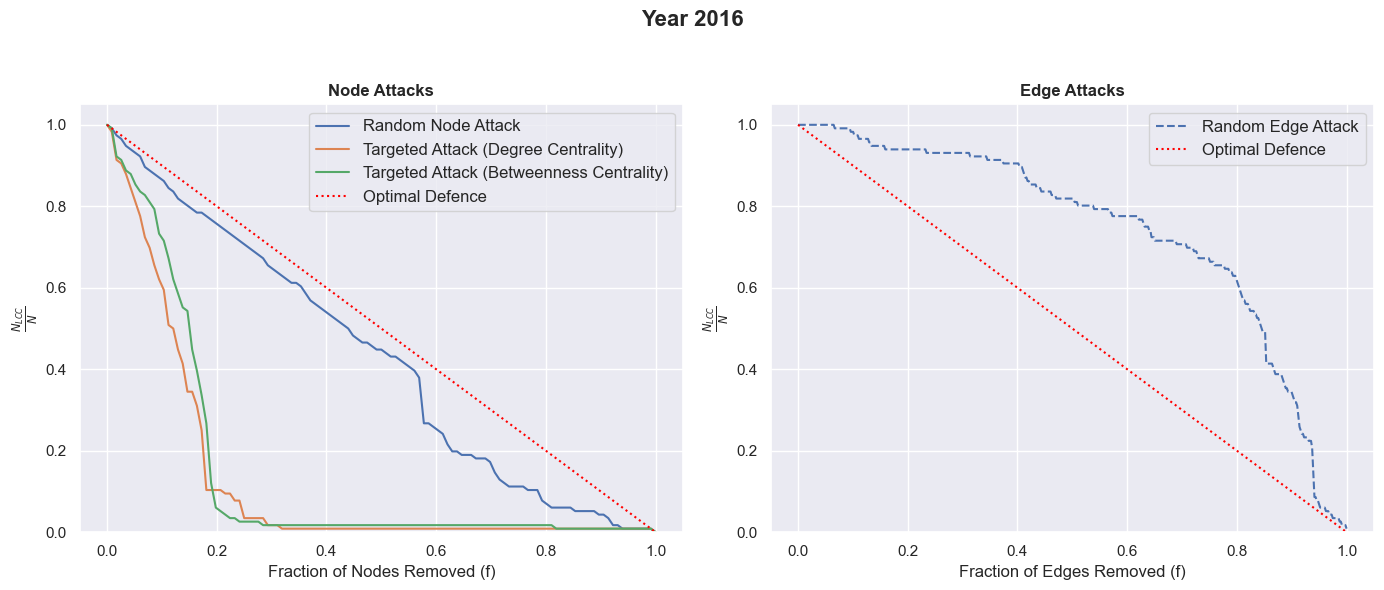

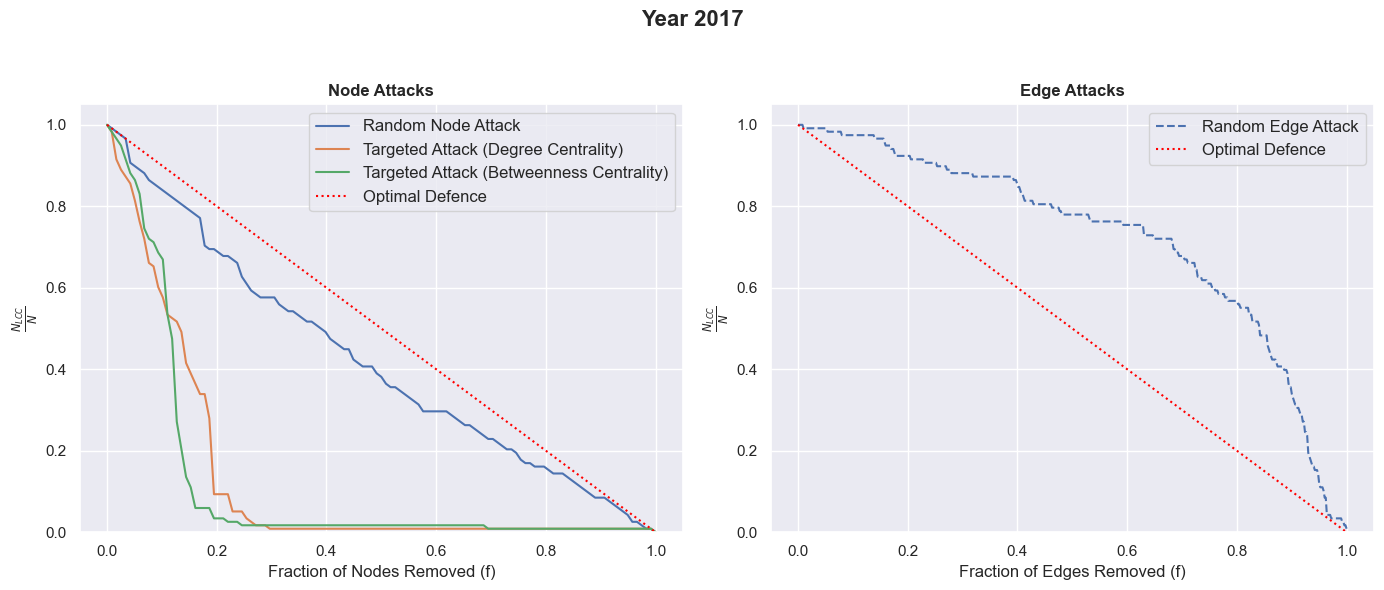

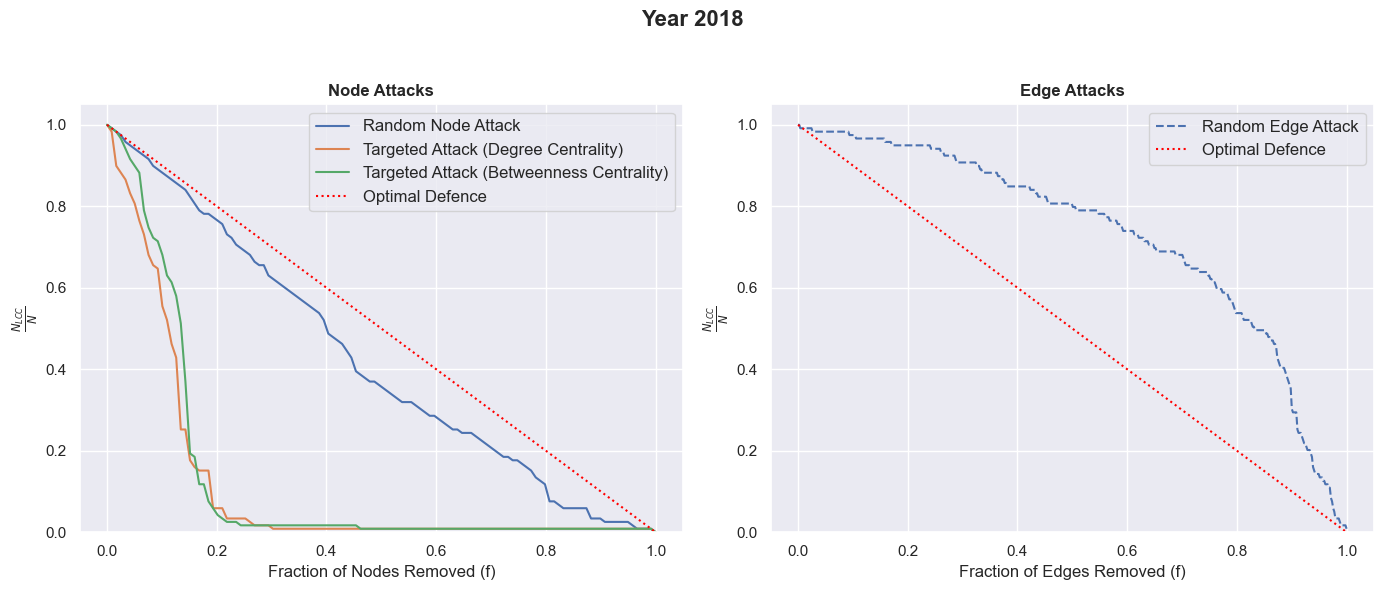

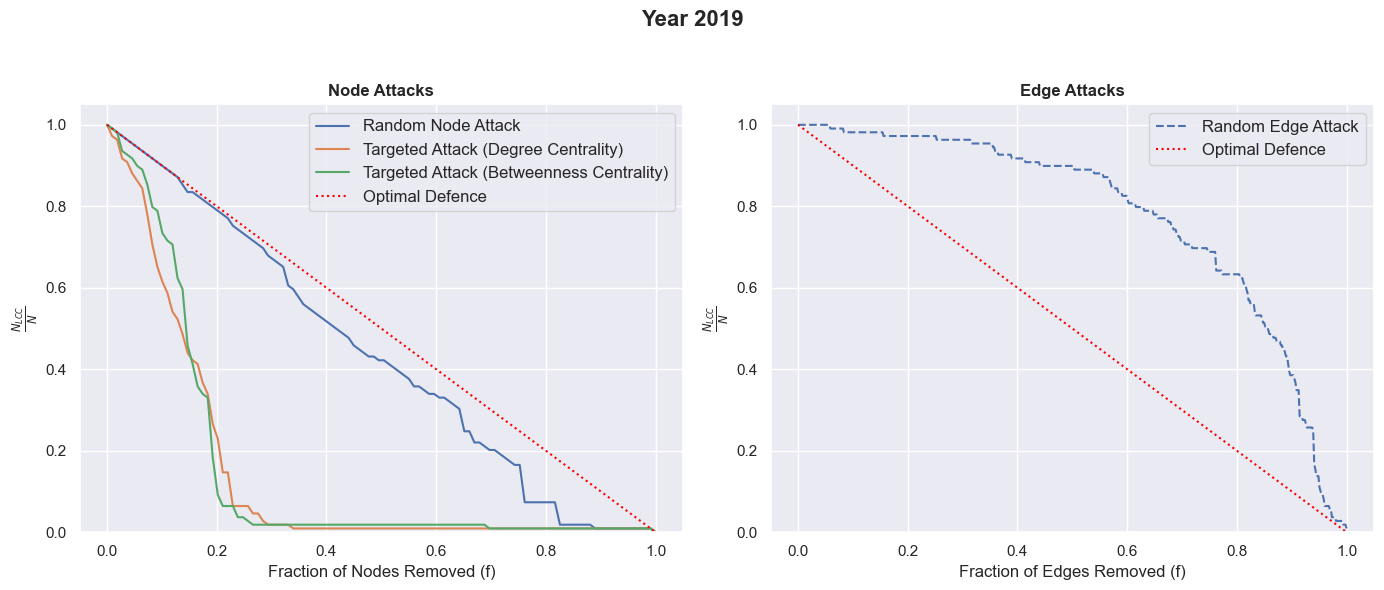

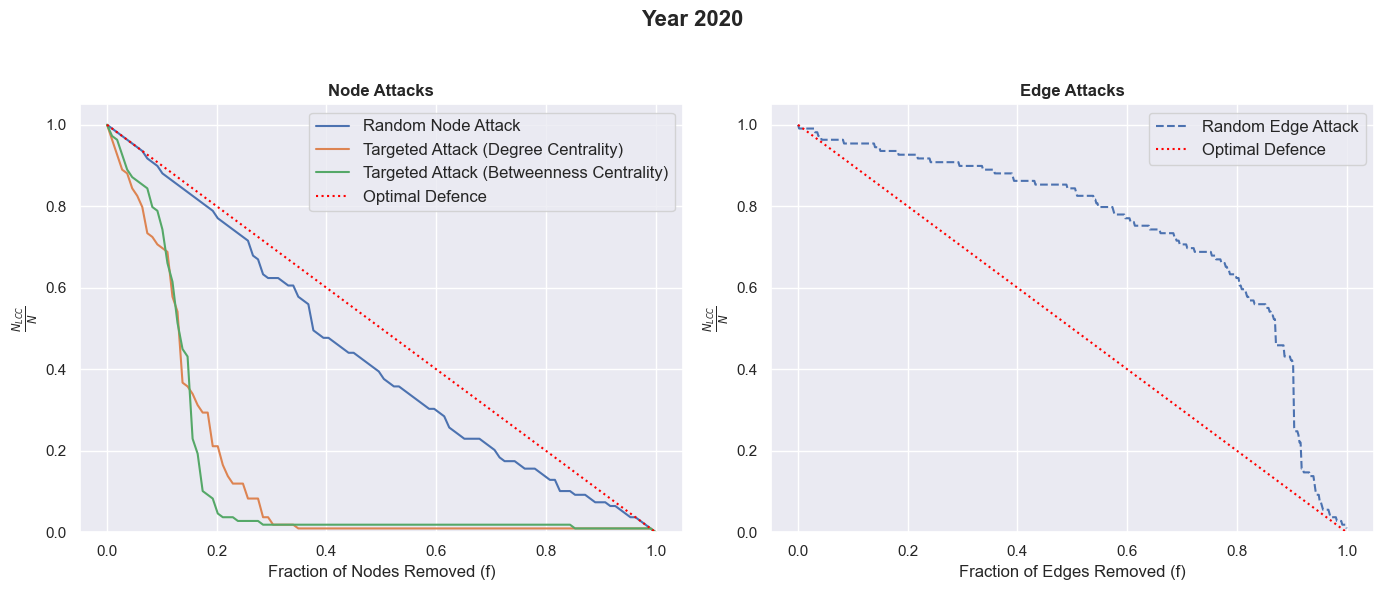

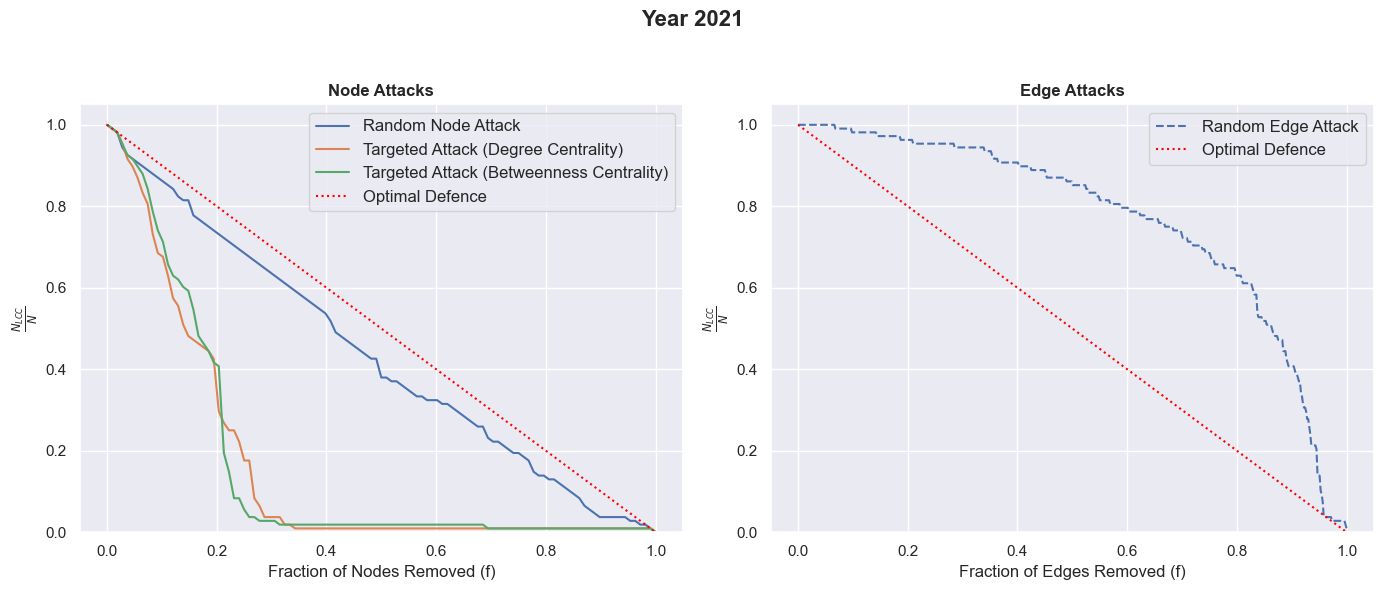

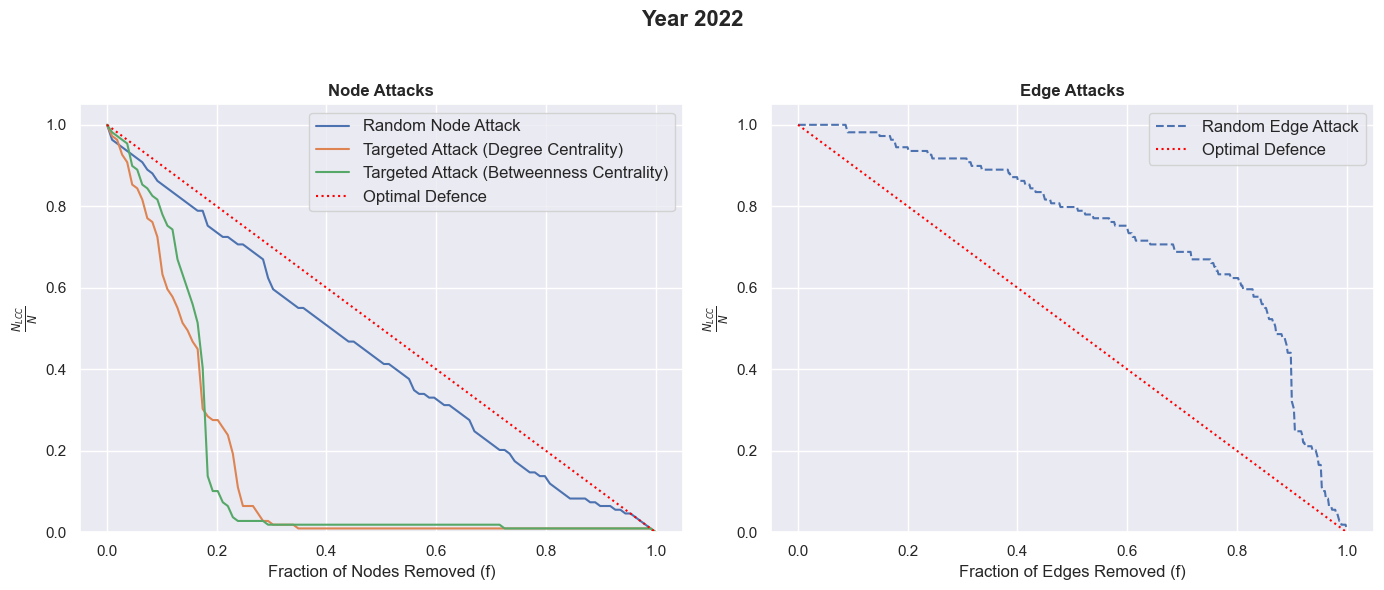

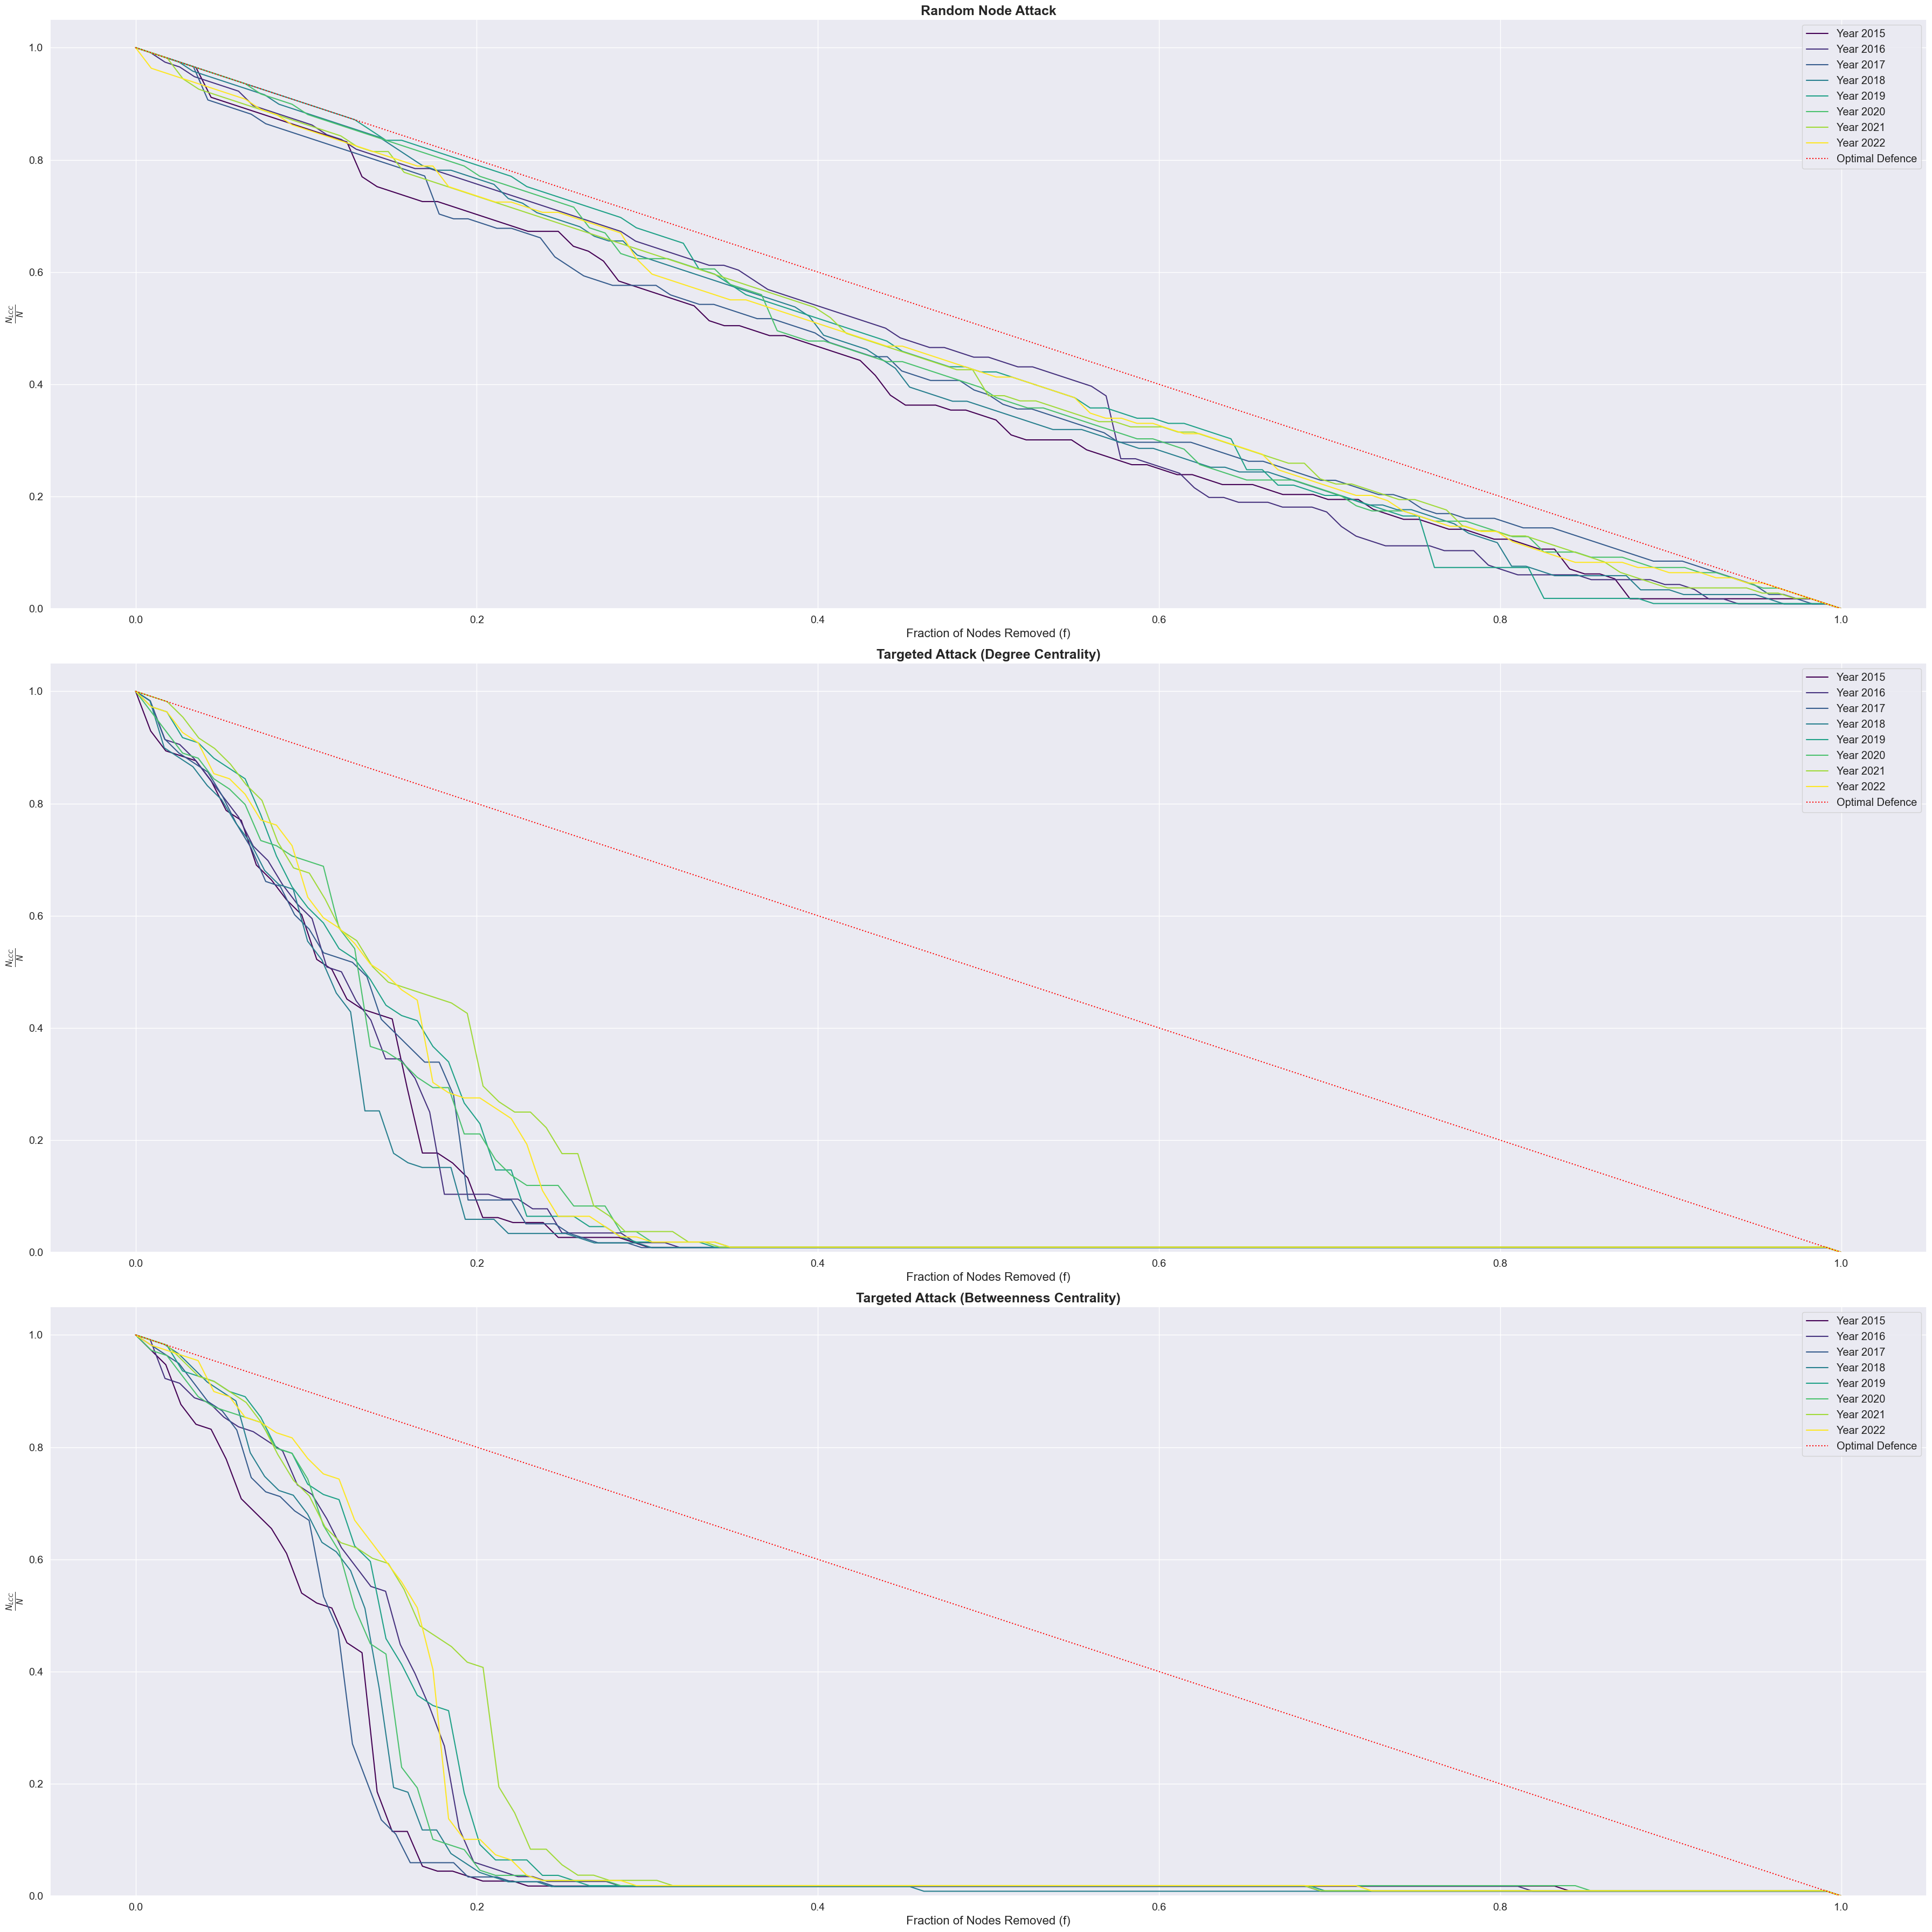

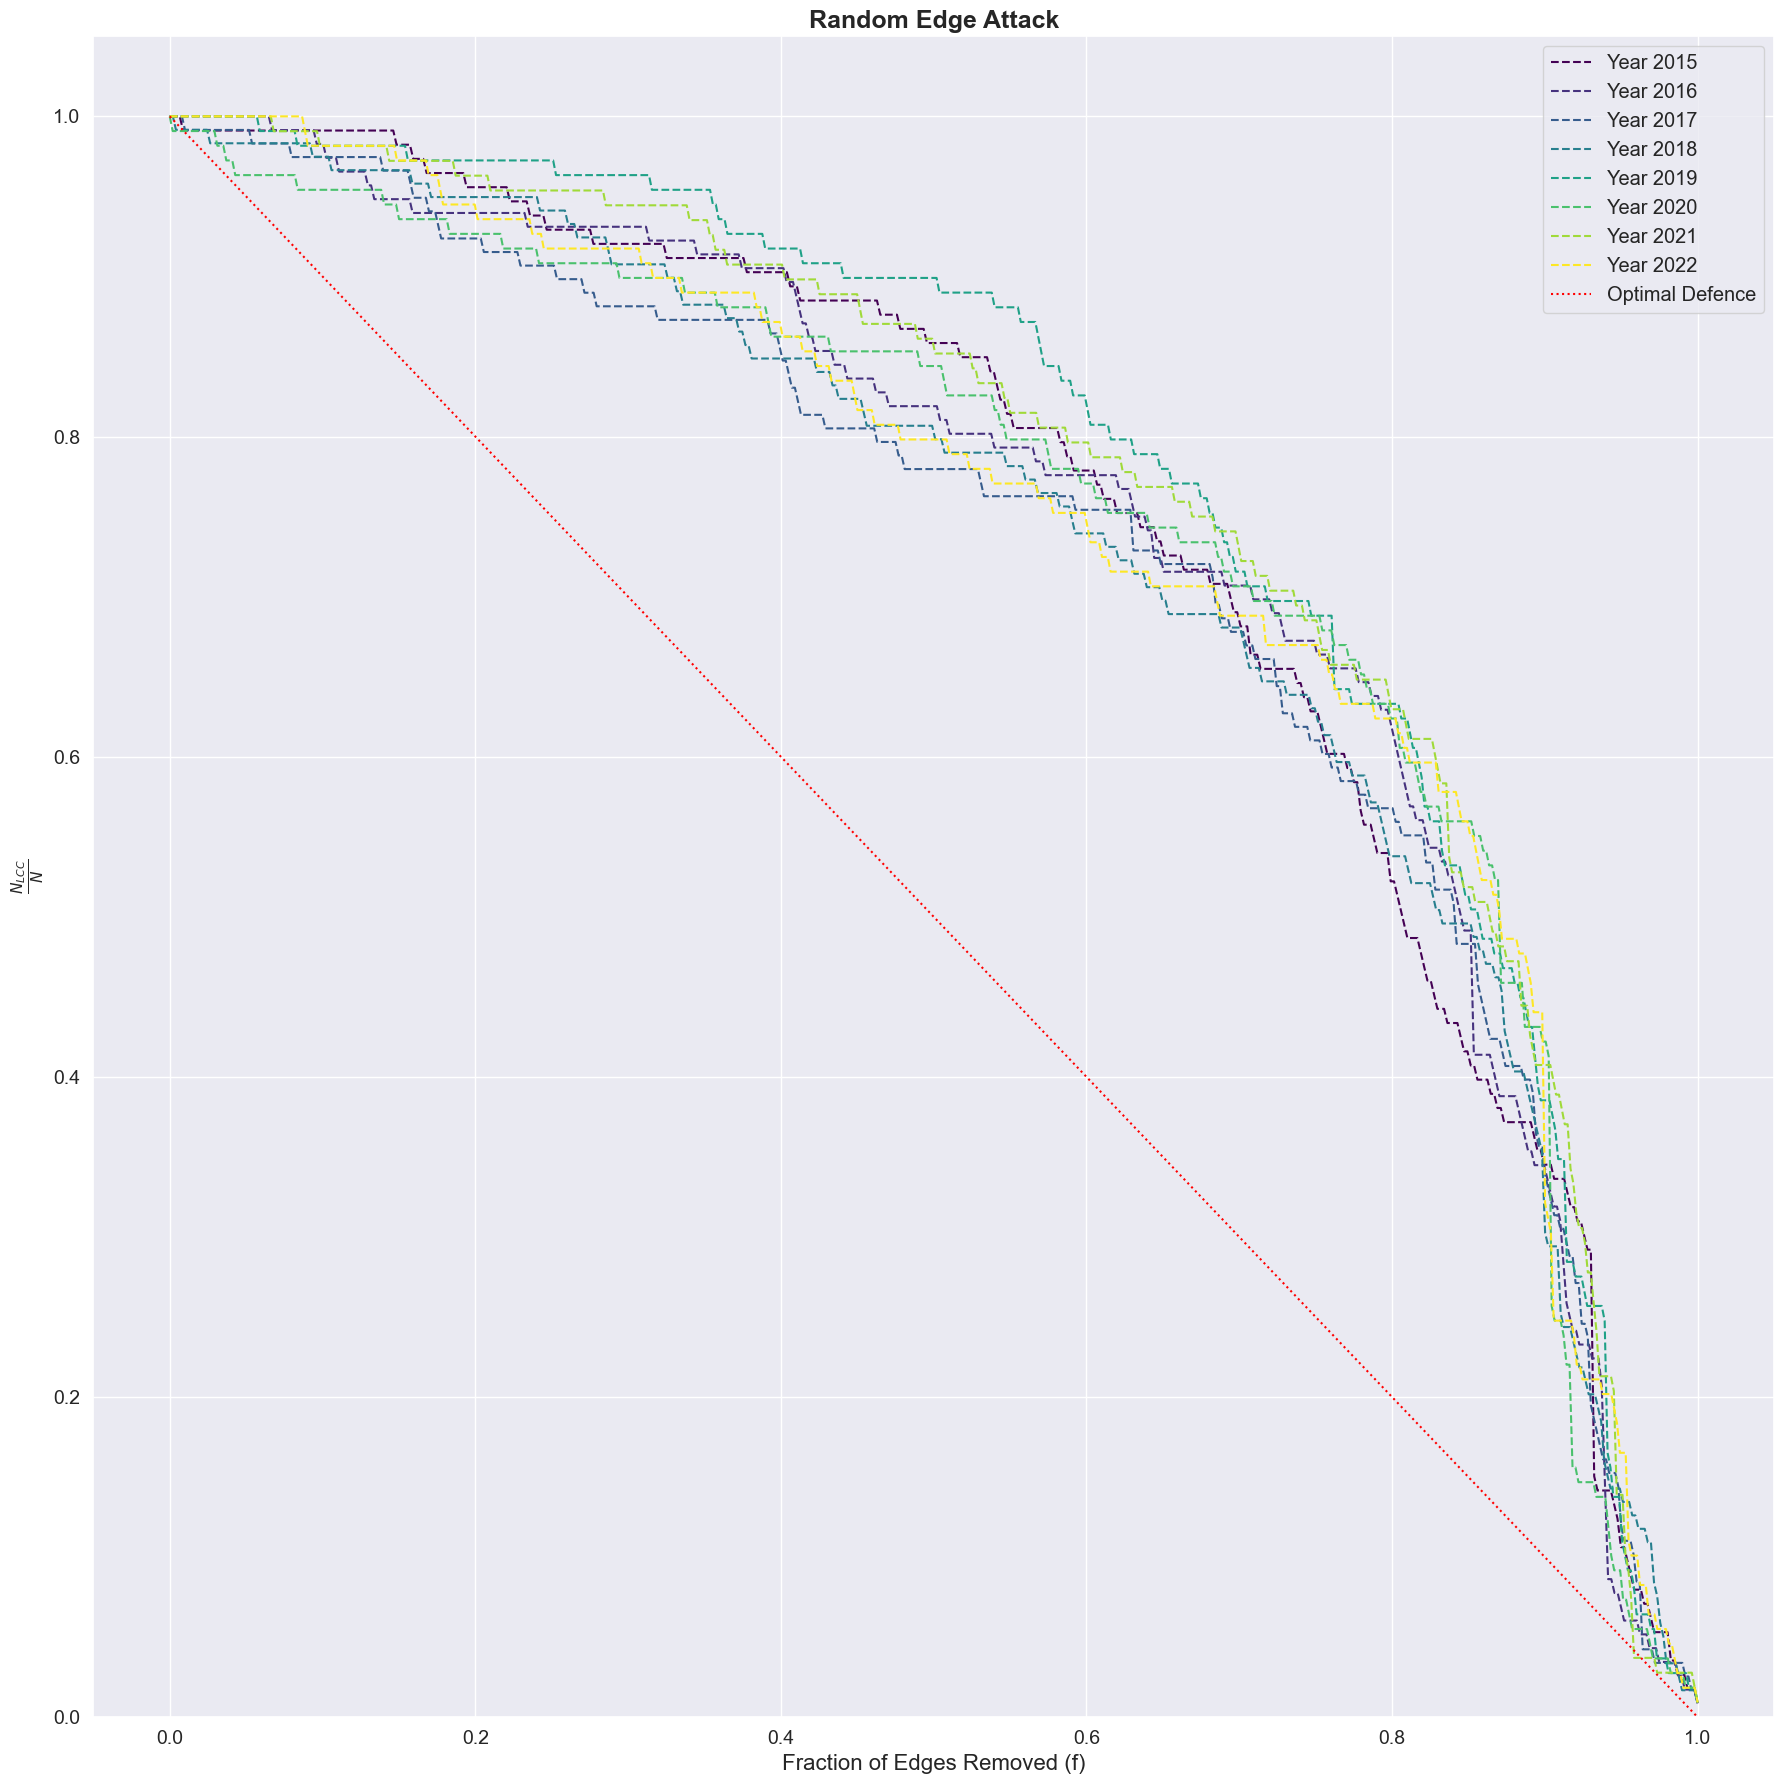

In [11]:
import polars as pl
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

##############################################
# Setup and Filtering Data
##############################################

df_lithium = df.filter(pl.col("k") == 282520).to_pandas()

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)

years = sorted(df_lithium['t'].unique())

##############################################
# Constructing Yearly Networks
##############################################
yearly_graphs = {}
for y in years:
    df_year = df_lithium[df_lithium['t'] == y]
    df_agg = df_year.groupby(['export_country','import_country'], as_index=False)['v'].sum()
    G = nx.Graph()
    for _, row in df_agg.iterrows():
        exporter = row['export_country']
        importer = row['import_country']
        value = row['v']
        if exporter != importer:
            if G.has_edge(exporter, importer):
                G[exporter][importer]['weight'] += value
            else:
                G.add_edge(exporter, importer, weight=value)
    yearly_graphs[y] = G
    
##############################################
# Attack Simulations
##############################################
def largest_cc_size(G):
    if len(G) == 0:
        return 0
    return len(max(nx.connected_components(G), key=len))

def random_node_attack(G):
    """Remove nodes at random one by one, record LCC size."""
    nodes = list(G.nodes())
    random.shuffle(nodes)
    lcc_sizes = []
    G_copy = G.copy()
    initial_lcc = largest_cc_size(G_copy)
    lcc_sizes.append(initial_lcc)
    
    for n in nodes:
        G_copy.remove_node(n)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_degree_attack(G):
    """Remove highest-degree node iteratively."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]
    
    while len(G_copy) > 0:
        deg = dict(G_copy.degree(weight='weight'))
        target = max(deg, key=deg.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_betweenness_dynamic_attack(G):
    """Remove highest betweenness node each iteration (dynamic recalculation)."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]

    while len(G_copy) > 0:
        if len(G_copy) == 1:
            G_copy.remove_node(list(G_copy.nodes())[0])
            lcc_sizes.append(largest_cc_size(G_copy))
            break

        bet = nx.betweenness_centrality(G_copy, weight='weight')
        target = max(bet, key=bet.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def random_edge_attack(G):
    """Remove edges at random one by one, record LCC size."""
    G_copy = G.copy()
    edges = list(G_copy.edges())
    random.shuffle(edges)
    lcc_sizes = [largest_cc_size(G_copy)]
    for e in edges:
        G_copy.remove_edge(*e)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

##############################################
# Prepare results_list for plot_attacks
##############################################
results_list = []
for y in years:
    G = yearly_graphs[y]
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    random_node_lcc = random_node_attack(G)
    targeted_deg_lcc = targeted_degree_attack(G)
    targeted_bet_lcc = targeted_betweenness_dynamic_attack(G)
    random_edge_lcc = random_edge_attack(G)

    results = {
        'title': f"Year {y}",
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'random_node': random_node_lcc,
        'targeted_degree': targeted_deg_lcc,
        'targeted_betweenness_dynamic': targeted_bet_lcc,
        'random_edge': random_edge_lcc
    }
    results_list.append(results)

##############################################
# The plot_attacks function provided earlier
##############################################
def plot_attacks(results_list):

    attack_types_node = ['random_node', 'targeted_degree', 'targeted_betweenness_dynamic']
    attack_types_edge = ['random_edge']

    attack_labels = {
        'random_node': 'Random Node Attack',
        'random_edge': 'Random Edge Attack',
        'targeted_degree': 'Targeted Attack (Degree Centrality)',
        'targeted_betweenness_dynamic': 'Targeted Attack (Betweenness Centrality)'
    }

    graph_results = {}

    for results in results_list:
        title = results['title']
        num_nodes = results['num_nodes']
        num_edges = results['num_edges']

        graph_results[title] = {'num_nodes': num_nodes, 'num_edges': num_edges}

        for attack in attack_labels.keys():
            if attack in results:
                lcc_sizes = results[attack]
                initial_lcc_size = lcc_sizes[0]
                sizes = [size / initial_lcc_size for size in lcc_sizes]

                if attack in attack_types_node:
                    fractions_removed = [(i) / num_nodes for i in range(len(sizes))]
                elif attack in attack_types_edge:
                    fractions_removed = [(i) / num_edges for i in range(len(sizes))]
                else:
                    continue

                graph_results[title][attack] = {
                    'fractions_removed': fractions_removed,
                    'sizes': sizes
                }

    ##############################################
    # Plot Individual Year Figures
    ##############################################
    for title, data in graph_results.items():
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
        fig.suptitle(title, fontsize=16, fontweight='bold')

        ax = axs[0]
        for attack in attack_types_node:
            if attack in data:
                fractions_removed = data[attack]['fractions_removed']
                sizes = data[attack]['sizes']
                ax.plot(fractions_removed, sizes, label=attack_labels[attack])

        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Nodes Removed (f)", fontsize=12)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=12)
        ax.set_title("Node Attacks", fontweight="bold")
        ax.legend(fontsize='medium')
        ax.grid(True)
        ax.set_ylim(0, 1.05)

        ax = axs[1]
        for attack in attack_types_edge:
            if attack in data:
                fractions_removed = data[attack]['fractions_removed']
                sizes = data[attack]['sizes']
                ax.plot(fractions_removed, sizes, label=attack_labels[attack], linestyle='--')
        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Edges Removed (f)", fontsize=12)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=12)
        ax.set_title("Edge Attacks", fontweight="bold")
        ax.legend(fontsize='medium')
        ax.grid(True)
        ax.set_ylim(0, 1.05)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    ##############################################
    # Prepare data for Aggregated Plots
    ##############################################
    attack_results_node = {attack: {} for attack in attack_types_node}
    attack_results_edge = {attack: {} for attack in attack_types_edge}

    for results in results_list:
        title = results['title']
        num_nodes = results['num_nodes']
        num_edges = results['num_edges']

        for attack in attack_labels.keys():
            if attack in results:
                lcc_sizes = results[attack]
                initial_lcc_size = lcc_sizes[0]
                sizes = [size / initial_lcc_size for size in lcc_sizes]

                if attack in attack_types_node:
                    fractions_removed = [(i) / num_nodes for i in range(len(sizes))]
                    attack_results_node[attack][title] = (fractions_removed, sizes)
                elif attack in attack_types_edge:
                    fractions_removed = [(i) / num_edges for i in range(len(sizes))]
                    attack_results_edge[attack][title] = (fractions_removed, sizes)

    cmap = plt.get_cmap("viridis")

    ##############################################
    # Aggregated Node Attacks
    ##############################################
    num_attacks_node = len(attack_types_node)
    cols = 1
    rows = (num_attacks_node + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(36, 36))
    axs = axs.flatten()
    
    for idx, attack in enumerate(attack_types_node):
        ax = axs[idx]
        titles = list(attack_results_node[attack].keys())

        titles = [t for t in titles if int(t.split()[-1]) >= 2015]
    
        N = len(titles)
        for i, t in enumerate(titles):
            fractions_removed, sizes = attack_results_node[attack][t]
            color = cmap(i / max(1, N-1))
            ax.plot(fractions_removed, sizes, label=t, color=color)
    
        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Nodes Removed (f)", fontsize=16)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=16)
        ax.set_title(attack_labels[attack], fontweight="bold", fontsize=18)
        ax.grid(True)
        ax.legend(fontsize='large', loc='upper right')
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    for k in range(num_attacks_node, rows*cols):
        fig.delaxes(axs[k])
    
    plt.tight_layout()
    plt.show()
    
    ##############################################
    # Aggregated Edge Attacks
    ##############################################
    num_attacks_edge = len(attack_types_edge)
    fig, axs = plt.subplots(1, num_attacks_edge, figsize=(18, 18))
    if num_attacks_edge == 1:
        axs = [axs]
    
    for idx, attack in enumerate(attack_types_edge):
        ax = axs[idx]
        titles = list(attack_results_edge[attack].keys())

        titles = [t for t in titles if int(t.split()[-1]) >= 2015]
    
        N = len(titles)
        for i, t in enumerate(titles):
            fractions_removed, sizes = attack_results_edge[attack][t]
            color = cmap(i / max(1, N-1))
            ax.plot(fractions_removed, sizes, label=t, linestyle='--', color=color)
    
        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Edges Removed (f)", fontsize=16)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=16)
        ax.set_title(attack_labels[attack], fontweight="bold", fontsize=18)
        ax.grid(True)
        ax.legend(fontsize='large', loc='upper right')
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.show()

plot_attacks(results_list)

## Macro HHI Index

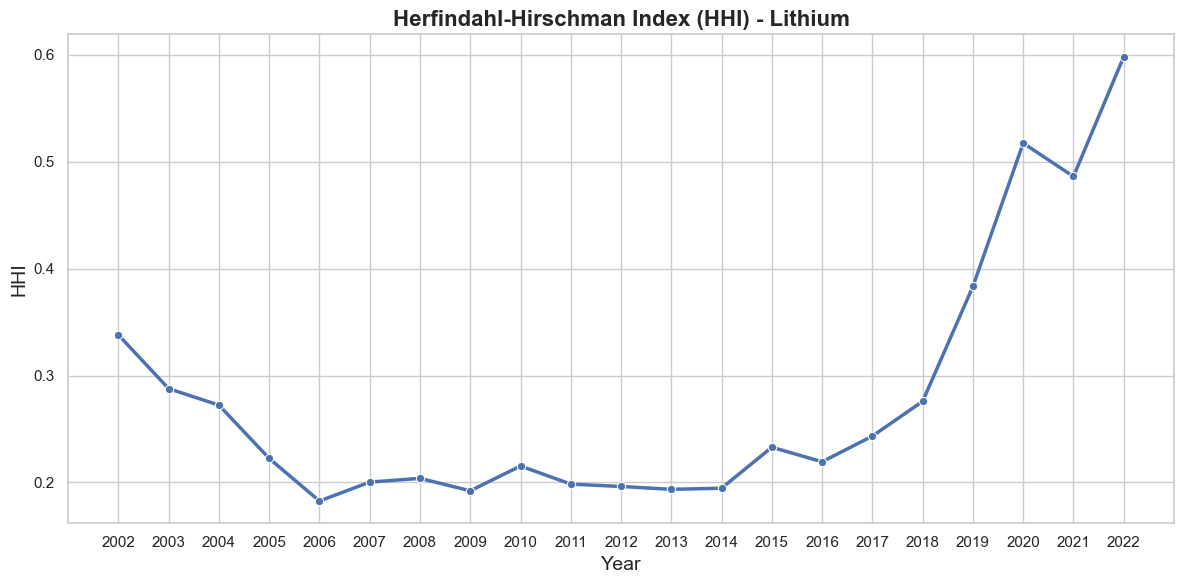

In [12]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_lithium = df.filter(pl.col("k") == 282520).to_pandas()
df_lithium['t'] = df_lithium['t'].astype(int)

yearly_exports = (
    df_lithium.groupby(["t", "export_country"], as_index=False)["v"].sum()
)

years_list = []
hhi_list = []

for year, grp in yearly_exports.groupby("t"):
    total_exports = grp["v"].sum()
    grp["share"] = grp["v"] / total_exports
    hhi = (grp["share"] ** 2).sum()
    
    years_list.append(year)
    hhi_list.append(hhi)

hhi_df = pd.DataFrame({"year": years_list, "HHI": hhi_list})
hhi_df["year"] = hhi_df["year"].astype(int)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=hhi_df, x="year", y="HHI", marker="o", linewidth=2.5)
plt.title("Herfindahl-Hirschman Index (HHI) - Lithium", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("HHI", fontsize=14)
plt.xticks(hhi_df["year"].unique().astype(int))
plt.tight_layout()
plt.show()

In [13]:
##############################################
# Interpretation:
# If the HHI is close to 1, it means one exporter dominates nearly all trade.
# HHI increased sharply from 2017 onwards leading to a more concentrated network
##############################################

## Network Metrics Over Time

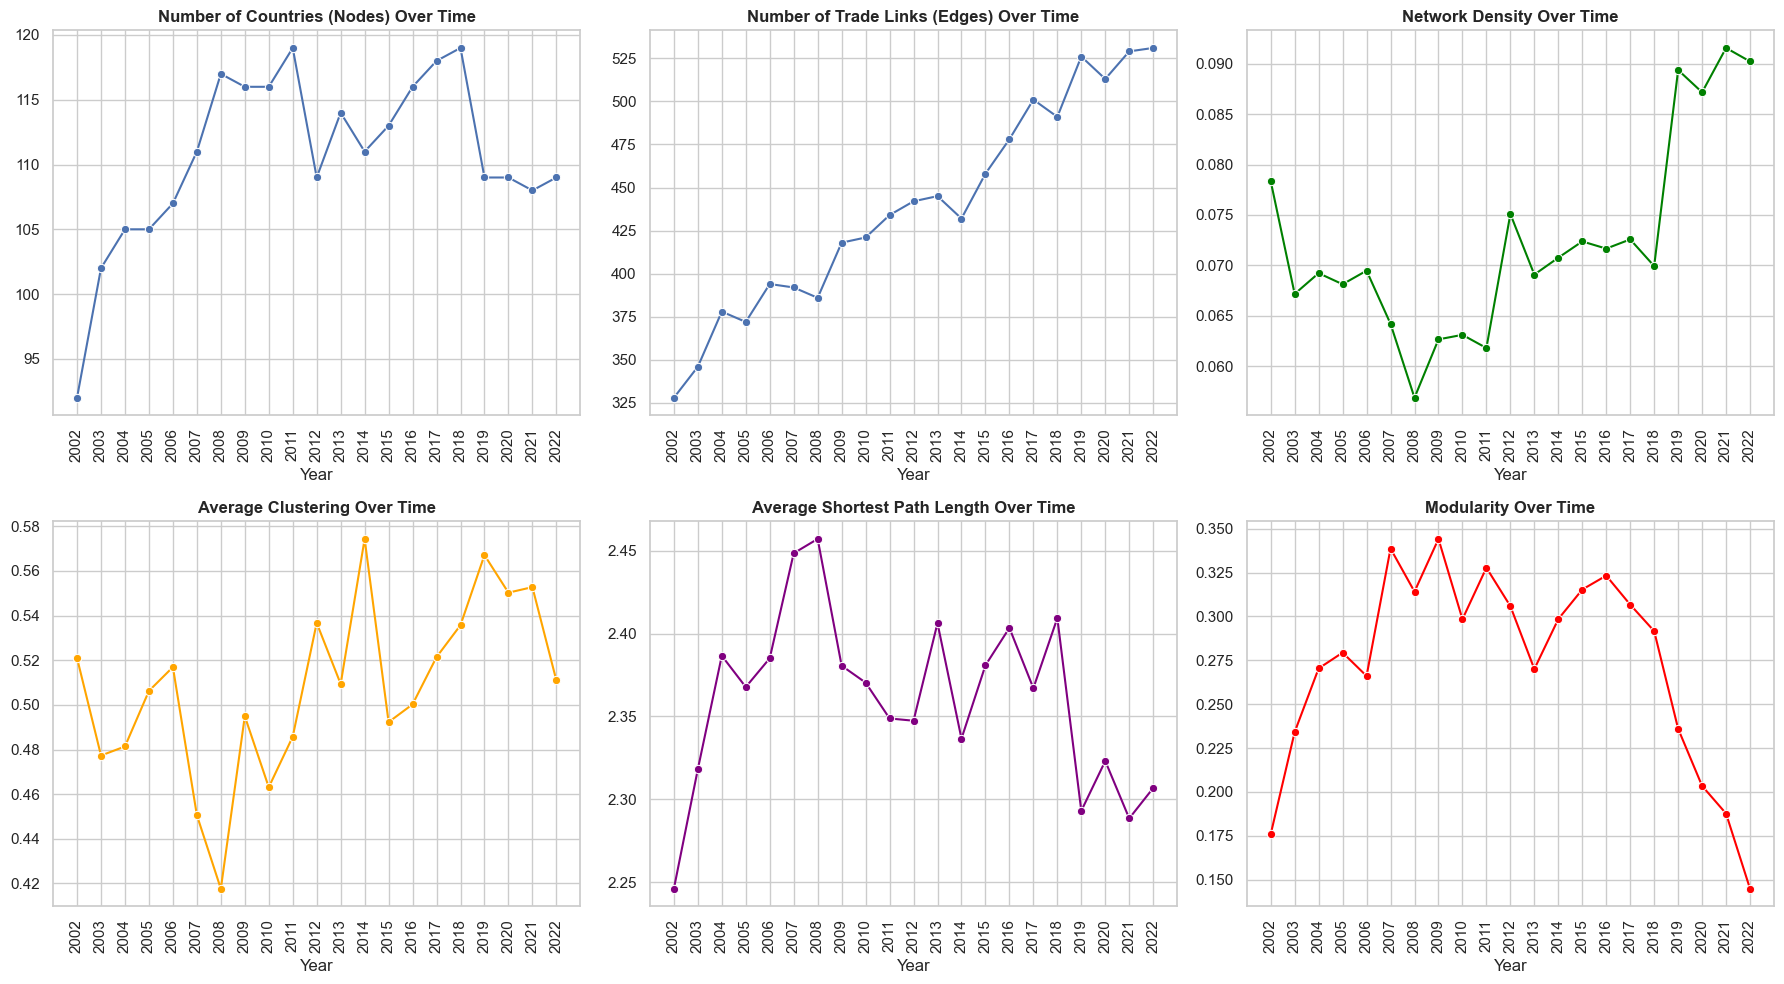

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from community import community_louvain

df_lithium = df.filter(pl.col("k") == 282520).to_pandas()

years = sorted(df_lithium['t'].unique())

##############################################
# Building Yearly Graphs
##############################################
yearly_graphs = {}
for y in years:
    df_year = df_lithium[df_lithium['t'] == y]
    df_agg = df_year.groupby(['export_country','import_country'], as_index=False)['v'].sum()
    G = nx.Graph()
    for _, row in df_agg.iterrows():
        exporter = row['export_country']
        importer = row['import_country']
        value = row['v']
        if exporter != importer:
            if G.has_edge(exporter, importer):
                G[exporter][importer]['weight'] += value
            else:
                G.add_edge(exporter, importer, weight=value)
    yearly_graphs[y] = G

##############################################
# Network Metrics Over Time
##############################################
results = {
    'year': [],
    'num_nodes': [],
    'num_edges': [],
    'density': [],
    'avg_clustering': [],
    'avg_shortest_path': [],
    'modularity': [],
    'num_communities': []
}

for y, G in yearly_graphs.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    density = nx.density(G)

    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    
    # Average shortest path length
    if nx.is_connected(G):
        avg_sp = nx.average_shortest_path_length(G)
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        avg_sp = nx.average_shortest_path_length(G_sub)

    # Community Detection
    partition = community_louvain.best_partition(G, weight='weight')
    mod = community_louvain.modularity(partition, G, weight='weight')
    num_com = len(set(partition.values()))

    results['year'].append(y)
    results['num_nodes'].append(num_nodes)
    results['num_edges'].append(num_edges)
    results['density'].append(density)
    results['avg_clustering'].append(avg_clustering)
    results['avg_shortest_path'].append(avg_sp)
    results['modularity'].append(mod)
    results['num_communities'].append(num_com)

results_df = pd.DataFrame(results)

##############################################
# Visualization
##############################################
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

sns.lineplot(data=results_df, x='year', y='num_nodes', ax=axs[0], marker='o')
axs[0].set_title("Number of Countries (Nodes) Over Time", fontweight="bold")
axs[0].set_xticks(results_df["year"].unique().astype(int))
axs[0].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='num_edges', ax=axs[1], marker='o')
axs[1].set_title("Number of Trade Links (Edges) Over Time", fontweight="bold")
axs[1].set_xticks(results_df["year"].unique().astype(int))
axs[1].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='density', ax=axs[2], marker='o', color='green')
axs[2].set_title("Network Density Over Time", fontweight="bold")
axs[2].set_xticks(results_df["year"].unique().astype(int))
axs[2].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='avg_clustering', ax=axs[3], marker='o', color='orange')
axs[3].set_title("Average Clustering Over Time", fontweight="bold")
axs[3].set_xticks(results_df["year"].unique().astype(int))
axs[3].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='avg_shortest_path', ax=axs[4], marker='o', color='purple')
axs[4].set_title("Average Shortest Path Length Over Time", fontweight="bold")
axs[4].set_xticks(results_df["year"].unique().astype(int))
axs[4].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='modularity', ax=axs[5], marker='o', color='red')
axs[5].set_title("Modularity Over Time", fontweight="bold")
axs[5].set_xticks(results_df["year"].unique().astype(int))
axs[5].tick_params(axis='x', labelrotation=90)

for ax in axs:
    ax.set_xlabel("Year")
    ax.set_ylabel("")
    ax.grid(True)

plt.tight_layout()
plt.show()

### Community Stability Over Time

Community Stability Over Time (NMI):
 [(2002, 2003, 0.3079150943303561), (2003, 2004, 0.127433212791437), (2004, 2005, 0.15852141133425693), (2005, 2006, 0.20095986472988245), (2006, 2007, 0.3583749898749134), (2007, 2008, 0.23094676138435313), (2008, 2009, 0.25629939865799994), (2009, 2010, 0.24433396536145646), (2010, 2011, 0.17601412779624925), (2011, 2012, 0.3138231464011897), (2012, 2013, 0.31761557671717344), (2013, 2014, 0.35303769213539576), (2014, 2015, 0.37476888011586296), (2015, 2016, 0.20670542445634438), (2016, 2017, 0.13896364567167538), (2017, 2018, 0.25383326750335006), (2018, 2019, 0.21884726014809894), (2019, 2020, 0.17097193707074496), (2020, 2021, 0.20370925003413712), (2021, 2022, 0.20865752985546424)]


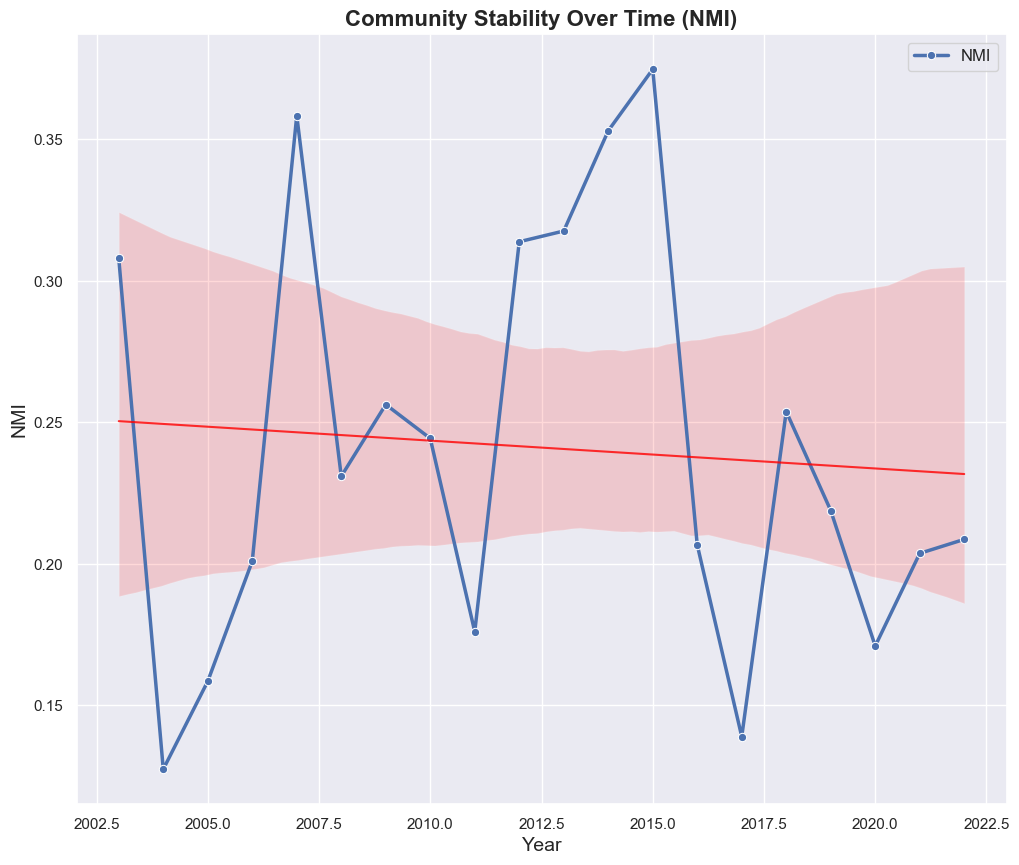

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics.cluster import normalized_mutual_info_score

##############################################
# Data Loading
##############################################
cc_df = loader.country_codes.to_pandas() 
country_code_to_name = dict(zip(cc_df["country_code"], cc_df["country_name"]))
country_code_to_iso3 = dict(zip(cc_df["country_code"], cc_df["country_iso3"]))

##############################################
# Communities Per Year
##############################################
year_communities = {}
for y, G in yearly_graphs.items():
    comms = greedy_modularity_communities(G, weight='weight')
    node2comm = {}
    for i, cset in enumerate(comms):
        for node in cset:
            node2comm[node] = i
    year_communities[y] = node2comm

##############################################
# Year-to-Year Community Stability (NMI)
##############################################
years_sorted = sorted(yearly_graphs.keys())
stability_results = []
for i in range(len(years_sorted)-1):
    y1, y2 = years_sorted[i], years_sorted[i+1]
    common_nodes = set(year_communities[y1].keys()).intersection(year_communities[y2].keys())
    c1 = [year_communities[y1][n] for n in common_nodes]
    c2 = [year_communities[y2][n] for n in common_nodes]
    nmi = normalized_mutual_info_score(c1, c2)
    stability_results.append((y1, y2, nmi))

print("Community Stability Over Time (NMI):\n", stability_results)

##############################################
# Visualization
##############################################
nmi_df = pd.DataFrame(stability_results, columns=['year_start', 'year_end', 'NMI'])
nmi_df['year'] = nmi_df['year_end']

plt.figure(figsize=(12, 10))
sns.set_theme(style="darkgrid")

sns.lineplot(x='year', y='NMI', data=nmi_df, marker='o', linewidth=2.5, label='NMI')
sns.regplot(x='year', y='NMI', data=nmi_df, scatter=False, 
            line_kws={'color': 'red', 'lw': 1.5, 'alpha':0.8})

plt.title("Community Stability Over Time (NMI)", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("NMI", fontsize=14)
plt.legend(fontsize=12)

Intra-Community Trade Ratio Over Time:
 [(2002, 0.5767354563241525), (2003, 0.580190733133207), (2004, 0.6126494858191425), (2005, 0.6361511820818214), (2006, 0.5321130316333584), (2007, 0.6607941757234326), (2008, 0.6038212613898888), (2009, 0.6160040771563469), (2010, 0.6557791668107102), (2011, 0.6670712861049807), (2012, 0.6649195610651842), (2013, 0.6247132223165967), (2014, 0.59430349478764), (2015, 0.5943208750939316), (2016, 0.6430614896304023), (2017, 0.6963090070039022), (2018, 0.7155275630364042), (2019, 0.8714628602239763), (2020, 0.8185099623735703), (2021, 0.7979872442987744), (2022, 0.8580488660995781)]


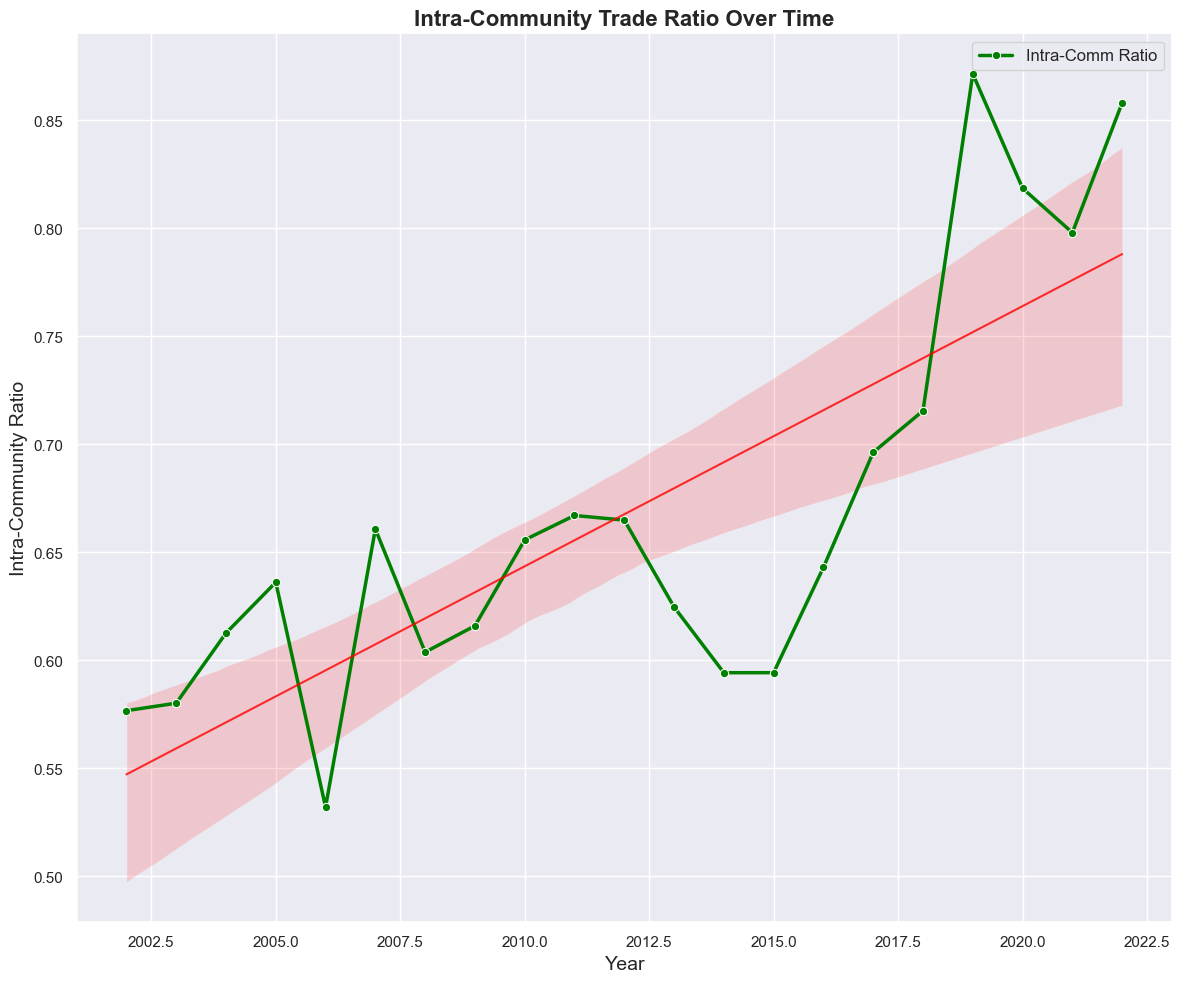

In [59]:
##############################################
# Compute Intra-Community Trade Ratio per Year
##############################################
intra_ratios = []
for y, G in yearly_graphs.items():
    comm_map = year_communities[y]
    intra_weight = 0.0
    inter_weight = 0.0

    for u, v, d in G.edges(data=True):
        if comm_map.get(u) == comm_map.get(v):
            intra_weight += d.get('weight', 0)
        else:
            inter_weight += d.get('weight', 0)

    total_weight = intra_weight + inter_weight
    if total_weight > 0:
        ratio = intra_weight / total_weight
        intra_ratios.append((y, ratio))

print("Intra-Community Trade Ratio Over Time:\n", intra_ratios)

intra_df = pd.DataFrame(intra_ratios, columns=['year', 'intra_ratio'])

##############################################
# Visualization
##############################################
plt.figure(figsize=(12, 10))
sns.set_theme(style="darkgrid")
sns.lineplot(x='year', y='intra_ratio', data=intra_df, marker='o', linewidth=2.5, color='green', label='Intra-Comm Ratio')
sns.regplot(x='year', y='intra_ratio', data=intra_df, scatter=False, 
            line_kws={'color': 'red', 'lw': 1.5, 'alpha':0.8})

plt.title("Intra-Community Trade Ratio Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Intra-Community Ratio", fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()